In [1]:
import numpy as np                # library for mathematical operations with arrays
import pandas as pd               # library for data frames; includes useful functions for date arithmetic
import xarray as xr               # library for arrays, especially tailored to weather data
import matplotlib.pyplot as plt   # library for basic plotting
import datetime                   # library for date manipulation

from functools import reduce
from scipy.stats import norm
from scipy.interpolate import interp1d

from os import path

import sys
sys.path.append("../src/confer_wp3/")
from plotting import plot_fields                                    # function for visualizing spatial data in a map
from lasso_forecast import calculate_tercile_probability_forecasts

The following two variables specify the paths where the forecast and observation data are stored:

In [2]:
era5_dir = '/nr/samba/PostClimDataNoBackup/CONFER/EASP/raw_predictors/'
chirps_dir = '/nr/samba/PostClimDataNoBackup/CONFER/EASP/precip/chirps/'
indices_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/fls/predictors/'
anomaly_dir = '/nr/samba/PostClimDataNoBackup/CONFER/EASP/precip/chirps/seasonal/halfdeg_res/'
eof_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/eofs/chirps/halfdeg_res/'
fcst_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/fls_pred/chirps/seasonal/halfdeg_res/'

Now, we set a number of parameters defining our forecast domain, training period, forecast year, etc.:

In [3]:
year_clm_start = 1993     # first year of the climatological reference period
year_clm_end = 2020       # last year of the climatological reference period

year_train_start = 1981   # first year of the training period
year_train_end = 2020     # last year of the training period

year_fcst = 2020          # year in which forecasts should be generated
month_init = 8            # month in which the forecast should be generated (based on data of the preceding month)
season = 'OND'

lon_bnds = [20, 53]       # longitude range of the domain of interest
lat_bnds = [-15, 23]      # latitude range of the domain of interest

period_clm = [year_clm_start, year_clm_end]
period_train = [year_train_start, year_train_end]

If not already available, load CHIRPS data, calculate seasonal precipitation anomalies, EOFs, and factor loading, and save out.

### Data loading

In [4]:
# Predictors: uwind200, uwind850, sst, chirps
# Dir: era5_dir or chirps_dir
    
def load_raw_data(dir, predictor, bounding_box, years, season=None):
    # Construct file path
    if predictor == "sst":
        pth = "sst/full.nc"
    elif predictor == "uwind200":
        pth = "uwind/200hpa/full.nc"
    elif predictor == "uwind850":
        pth = "uwind/850hpa/full.nc"
    elif predictor == "chirps":
        pth = "prec_raw.nc"
    file_path = f"{dir}{pth}"
    
     # Load data
    data = xr.open_dataset(file_path)
    
    if predictor == "chirps":
        # Subset data based on bounding box
        lon_min, lon_max, lat_min, lat_max = bounding_box
        data = data.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))
    
    # Subset data based on years
    data = data.sel(year=slice(years[0], years[-1]))
    
    # Aggregate by season if provided
    if predictor == "chirps" and season is not None:
        if season == 'OND':
            season_months = [10, 11, 12]
        elif season == 'MAM':
            season_months = [3, 4, 5]
        elif season == 'JJAS':
            season_months = [6, 7, 8, 9]
        data = data.sel(month=np.isin(data['month'], season_months))
        
        # Convert to NumPy array for easier manipulation
        data_np = data['prec'].values
        
        # Aggregate by summing over the selected months
        data = data.groupby('year').sum(dim='month', skipna=False)
    
    # Convert to NumPy arrays
    year = data['year'].values
    lon = data['lon'].values
    lat = data['lat'].values

    if predictor == "chirps":
        predictor_values = data['prec'].values # Shape: (year, lat, lon)
    elif predictor == "uwind200" or predictor == "uwind850":
        # #predictor_values = data['uwind'].values
        # month = data['month'].values
        # return year, lon, lat, month
        return data
    elif predictor == "sst":
        # #predictor_values = data['sst'].values
        # month = data['month'].values
        # return year, lon, lat, month
        return data
    
    return year, lon, lat, predictor_values

#### Loading tests

In [5]:
# ecmwf_data = xr.open_dataset(f"/nr/samba/PostClimDataNoBackup/CONFER/EASP/ecmwf/precip_new.nc", engine='netcdf4')
# ecmwf_data

## CHIRPS DATA

##### Loading data

In [6]:
# TESTING
test_dir = "/nr/samba/user/ahellevik/CONFER-WP3/testdata/"

# Load data
box = [lon_bnds[0], lon_bnds[1], lat_bnds[0], lat_bnds[1]]
year, lon, lat, prec_data = load_raw_data(chirps_dir, "chirps", box, [i for i in range(year_train_start, year_train_end+1)], season=season) # 1993, 2021
prec_data.shape
print("Loaded data shape:", prec_data.shape)
print("NaN values in loaded data:", np.isnan(prec_data).sum())

Loaded data shape: (40, 67, 59)
NaN values in loaded data: 76200


##### Calculate anomalies

In [7]:
# Restrict to the geographical bounds
lon_mask = (lon >= lon_bnds[0]) & (lon <= lon_bnds[1])
lat_mask = (lat >= lat_bnds[0]) & (lat <= lat_bnds[1])

lon = lon[lon_mask]
lat = lat[lat_mask]
prec_data = prec_data[:, lat_mask, :][:, :, lon_mask]

# Select the reference period using a boolean mask
ref_period_mask = (year >= year_clm_start) & (year <= year_clm_end)
ref_period_indices = np.where(ref_period_mask)[0]

# Calculate climatology (mean over the reference period)
climatology = np.nanmean(prec_data[ref_period_indices, :, :], axis=0)

# Calculate anomalies by subtracting climatology
anomalies = prec_data - climatology[np.newaxis, :, :]

print(prec_data.shape)
print(anomalies.shape)
# Verify NaNs are handled correctly
print("NaN values in prec_data:", np.isnan(prec_data).sum())
print("NaN values in anomalies:", np.isnan(anomalies).sum())

(40, 67, 59)
(40, 67, 59)
NaN values in prec_data: 76200
NaN values in anomalies: 76200


/tmp/ipykernel_52920/949136485.py:14: RuntimeWarning: Mean of empty slice
  climatology = np.nanmean(prec_data[ref_period_indices, :, :], axis=0)


##### Visualize calculation of anomalies for a random month/year pair

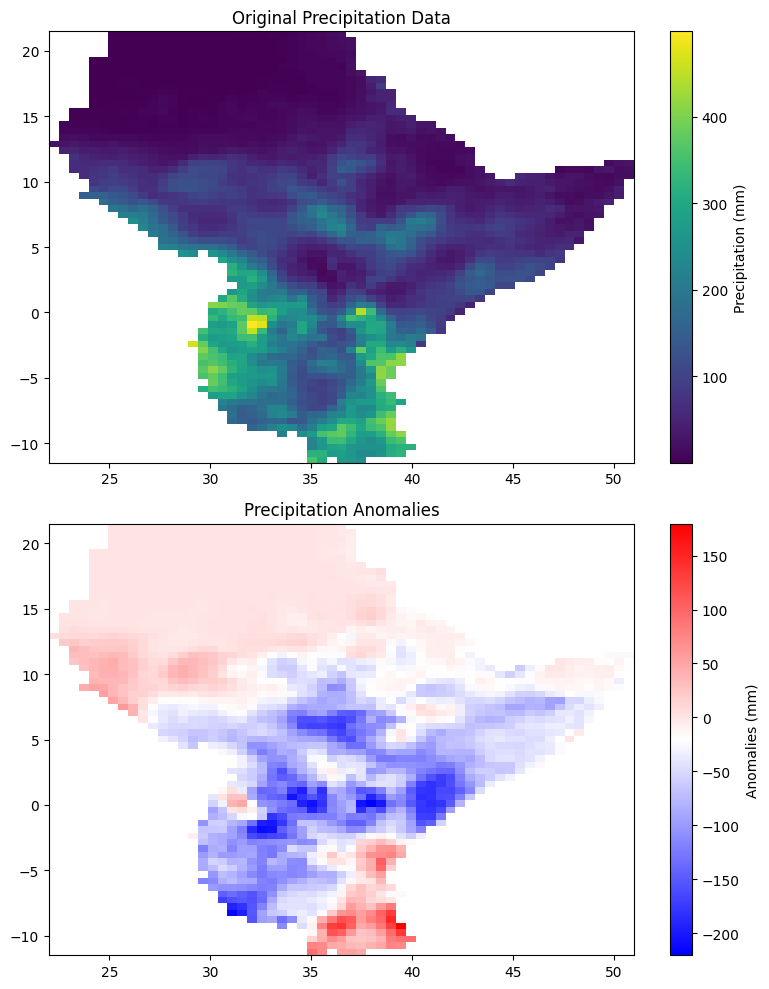

In [8]:
# Plot original precipitation data
plt.figure(figsize=(8, 10))  # Adjusting figsize for a more even aspect ratio
plt.subplot(2, 1, 1)
plt.title('Original Precipitation Data')
plt.imshow(prec_data[0, :, :], origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()], cmap='viridis', aspect='auto')
plt.colorbar(label='Precipitation (mm)')

# Plot anomalies
plt.subplot(2, 1, 2)
plt.title('Precipitation Anomalies')
plt.imshow(anomalies[0, :, :], origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()], cmap='bwr', aspect='auto')
plt.colorbar(label='Anomalies (mm)')
plt.tight_layout()
plt.show()

##### Transform anomalies to normal dist. using quantile mapping

In [9]:
def quantile_mapping(data, ref_indices):
    transformed_data = np.full_like(data, np.nan)
    
    # Standard deviation for the reference period at each grid point
    ref_period_std = np.nanstd(data[ref_indices, :, :], axis=0)
    
    for lat_idx in range(data.shape[1]):
        for lon_idx in range(data.shape[2]):
            ref_data = data[ref_indices, lat_idx, lon_idx]
            ref_data_valid = ref_data[~np.isnan(ref_data)]
            
            if ref_data_valid.size == 0:
                continue
            
            # Add small noise to avoid identical ranks
            ref_data_valid += abs(np.random.normal(0, 1e-10, ref_data_valid.shape))

            # Sort the reference data and calculate percentiles
            sorted_ref_data = np.sort(ref_data_valid)
            # Add small jitter to avoid repeated values
            jitter = np.random.normal(0, 1e-10, sorted_ref_data.shape)
            sorted_ref_data_jittered = sorted_ref_data + abs(jitter)
            n = ref_data_valid.size
            ref_percentiles = np.arange(1, n + 1) / (n + 1)
            
            # Calculate the normal scores for the percentiles
            ref_normal = norm.ppf(ref_percentiles)
            ref_min_outside_range = norm.ppf(1/(n+2))
            ref_max_outside_range = norm.ppf((n+1)/(n+2))

            # Interpolator for reference period quantiles
            interp_func = interp1d(sorted_ref_data_jittered, ref_normal, kind='linear', bounds_error=False, fill_value=(ref_min_outside_range, ref_max_outside_range))
            #interp_func = interp1d(sorted_ref_data_jittered, ref_normal, kind='linear', fill_value="extrapolate", bounds_error=False)
            
            all_years_data = data[:, lat_idx, lon_idx]
            valid_mask = ~np.isnan(all_years_data) 
            all_years_data_valid = all_years_data[valid_mask]
            
            # Add jitter to all_years_data_valid
            all_years_data_valid += np.random.normal(0, 1e-10, all_years_data_valid.shape)
            
            # Interpolation of normal quantiles using reference period
            all_years_normal = interp_func(all_years_data_valid)

            # Standardize the normal values using the reference period standard deviation
            all_years_normal_standardized = all_years_normal * ref_period_std[lat_idx, lon_idx]
            
            # Place standardized values back in the original array shape
            transformed_data[valid_mask, lat_idx, lon_idx] = all_years_normal_standardized
            #transformed_data[valid_mask, lat_idx, lon_idx] = all_years_normal
            # Check for any new NaNs introduced
            if np.isnan(transformed_data[:, lat_idx, lon_idx]).sum() > np.isnan(data[:, lat_idx, lon_idx]).sum():
                print(f"New NaNs introduced at grid point (lat: {lat_idx}, lon: {lon_idx})")
                print(f"Original NaNs: {np.isnan(data[:, lat_idx, lon_idx]).sum()}")
                print(f"Transformed NaNs: {np.isnan(transformed_data[:, lat_idx, lon_idx]).sum()}")
                print(f"ref_data_valid: {ref_data_valid}")
                print(f"sorted_ref_data: {sorted_ref_data}")
                print(f"ref_percentiles: {ref_percentiles}")
                print(f"ref_normal: {ref_normal}")
                print(f"all_years_data_valid: {all_years_data_valid}")
                print(f"all_years_normal: {all_years_normal}")
                #print(f"all_years_normal_standardized: {all_years_normal_standardized}")
            
    return transformed_data

In [10]:
# Apply the transformation to the anomalies data
anomalies_normal = quantile_mapping(anomalies, ref_period_indices)
print(anomalies_normal.shape)

/nr/samba/user/ahellevik/CONFER-WP3/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(40, 67, 59)


In [11]:
# Saving, if wanted

# Convert to xarray DataArray for saving as NetCDF
anomalies_xr = xr.DataArray(anomalies, coords=[year, lat, lon], dims=['year', 'lat', 'lon'])
anomalies_normal_xr = xr.DataArray(anomalies_normal, coords=[year, lat, lon], dims=['year', 'lat', 'lon'])

# Save the anomalies and transformed anomalies
anomalies_xr.to_netcdf(f"{test_dir}/chirps_anomalies.nc")
anomalies_normal_xr.to_netcdf(f"{test_dir}/chirps_anomalies_normal.nc")

##### Plots to ensure processing anomalies went well

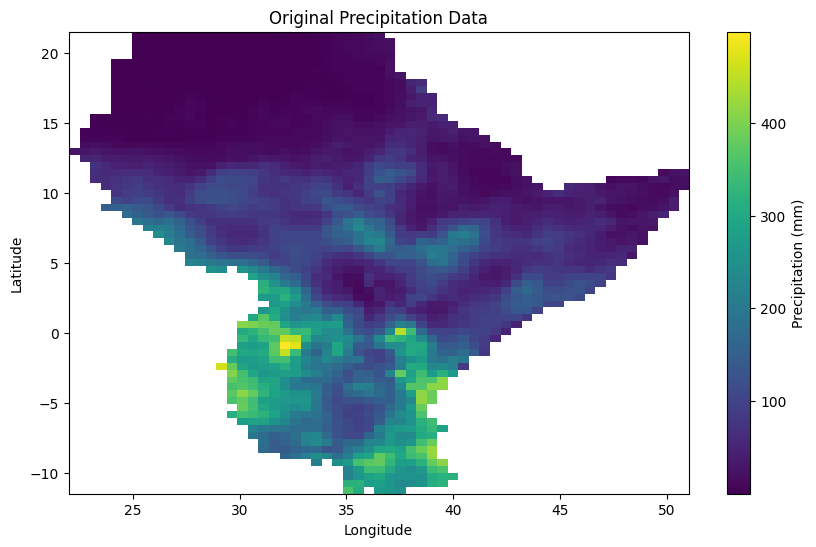

In [12]:
selected_year = 0  # First year in the dataset

plt.figure(figsize=(10, 6))
plt.title('Original Precipitation Data')
plt.imshow(prec_data[selected_year, :, :], origin='lower', extent=[lon.min(), lon.max(), lat.min(), lat.max()], cmap='viridis', aspect='auto')
plt.colorbar(label='Precipitation (mm)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

337.5006


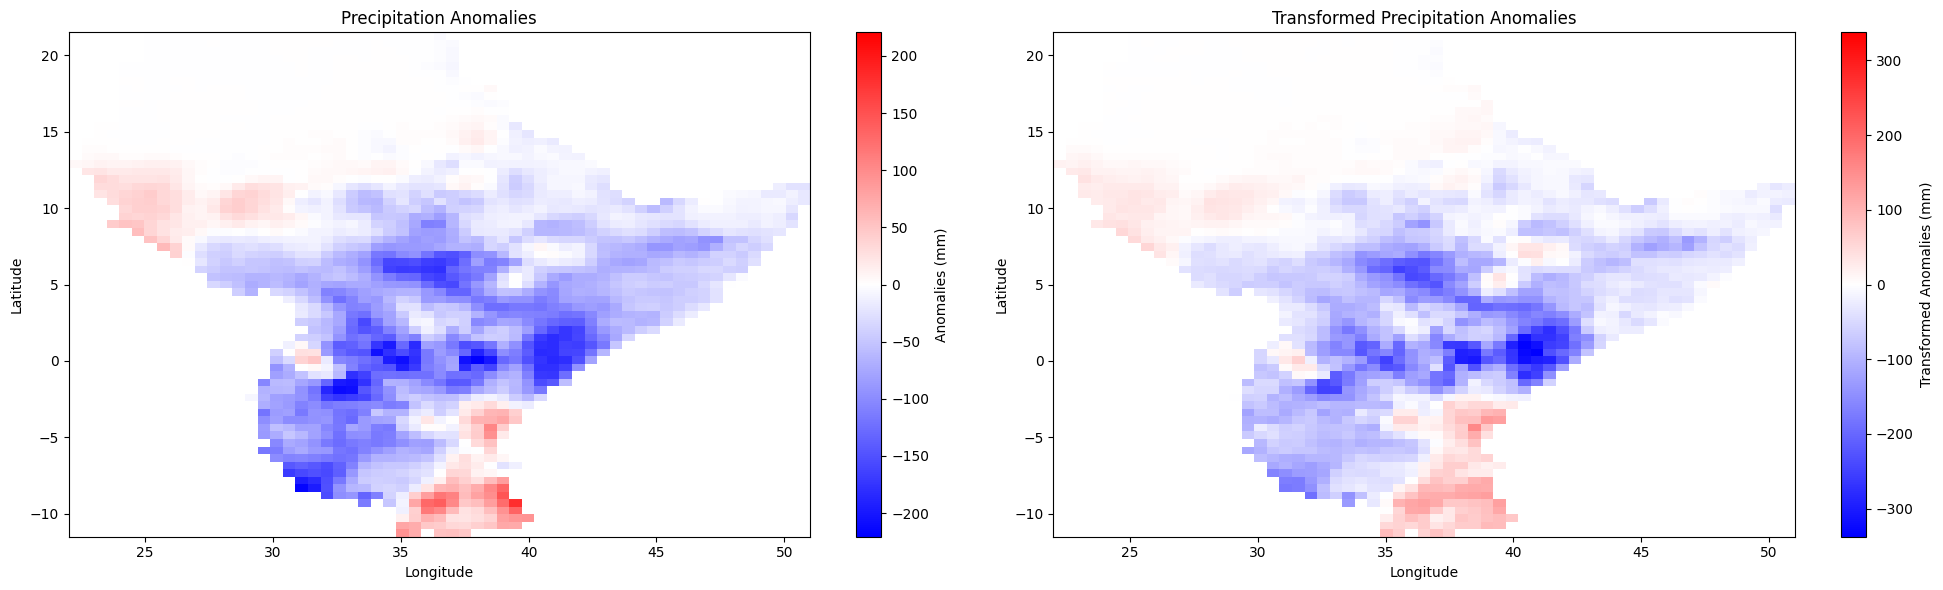

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

pltrg1 = np.nanmax(abs(anomalies[selected_year, :, :]))
# Plot Precipitation Anomalies
axes[0].set_title('Precipitation Anomalies')
img1 = axes[0].imshow(anomalies[selected_year, :, :], origin='lower', 
                      extent=[lon.min(), lon.max(), lat.min(), lat.max()], 
                      cmap='bwr', aspect='auto', vmin=-pltrg1, vmax=pltrg1)
fig.colorbar(img1, ax=axes[0], label='Anomalies (mm)')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')

# Plot Transformed Precipitation Anomalies
axes[1].set_title('Transformed Precipitation Anomalies')

pltrg = np.nanmax(abs(anomalies_normal[selected_year, :, :]))
print(pltrg)

img2 = axes[1].imshow(anomalies_normal[selected_year, :, :], origin='lower', 
                      extent=[lon.min(), lon.max(), lat.min(), lat.max()], 
                      cmap='bwr', aspect='auto', vmin=-pltrg, vmax=pltrg)
fig.colorbar(img2, ax=axes[1], label='Transformed Anomalies (mm)')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')

plt.tight_layout()
plt.show()


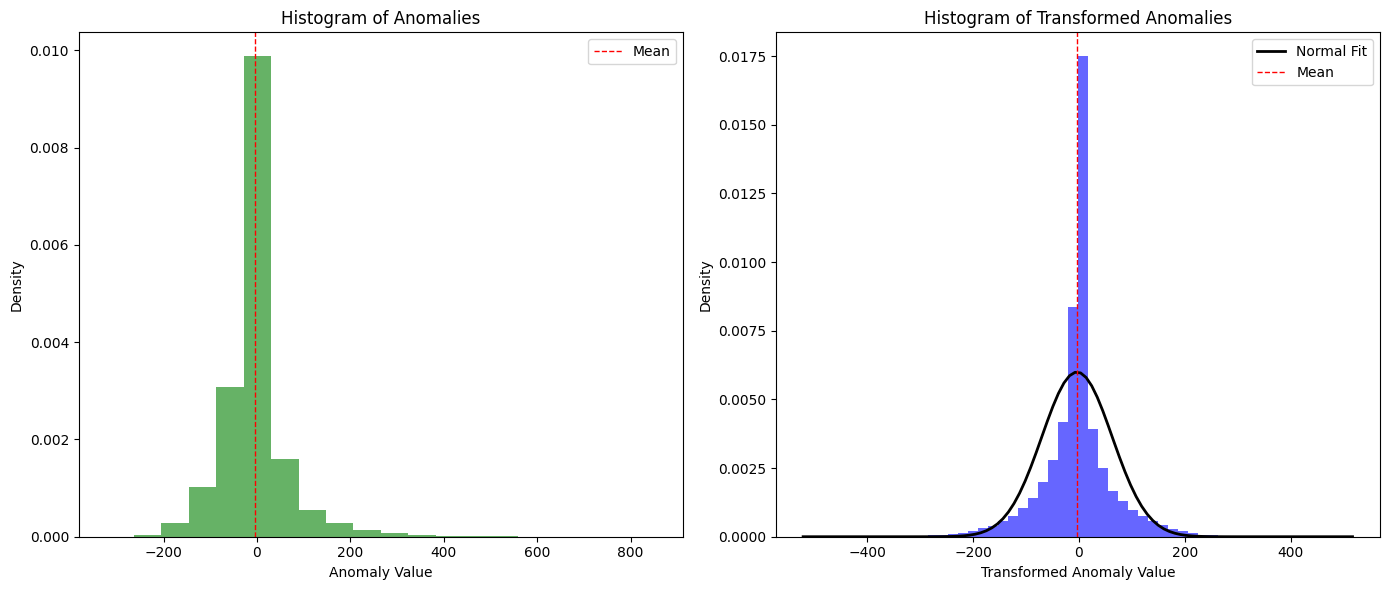

In [14]:
# Flatten the arrays and filter out non-finite values
anomalies_flat = anomalies[:, :, :].flatten()
anomalies_normal_flat = anomalies_normal[:, :, :].flatten()
#plt.hist(anomalies_normal_flat[~np.isnan(anomalies_normal_flat)], bins = 1000)
# Remove non-finite values
anomalies_flat = anomalies_flat[np.isfinite(anomalies_flat)]
anomalies_normal_flat = anomalies_normal_flat[~np.isnan(anomalies_normal_flat)]

plt.figure(figsize=(14, 6))

# Original anomalies histogram
plt.subplot(1, 2, 1)
plt.hist(anomalies_flat, bins=20, density=True, alpha=0.6, color='g')
plt.title('Histogram of Anomalies')
plt.xlabel('Anomaly Value')
plt.ylabel('Density')
plt.axvline(np.mean(anomalies_flat), color='r', linestyle='dashed', linewidth=1)
plt.legend(['Mean'])

# Transformed anomalies histogram
plt.subplot(1, 2, 2)
plt.hist(anomalies_normal_flat, bins=50, density=True, alpha=0.6, color='b')

# Overlay normal distribution curve
mu, std = norm.fit(anomalies_normal_flat)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

plt.title('Histogram of Transformed Anomalies')
plt.xlabel('Transformed Anomaly Value')
plt.ylabel('Density')
plt.axvline(mu, color='r', linestyle='dashed', linewidth=1)
plt.legend(['Normal Fit', 'Mean'])

plt.tight_layout()
plt.show()

In [15]:
print("Anomalies - mean:", np.nanmean(anomalies), "std:", np.nanstd(anomalies))
print("Transformed Anomalies - mean:", np.nanmean(anomalies_normal), "std:", np.nanstd(anomalies_normal))

# Check for any inf values
print("Inf values in anomalies:", np.isinf(anomalies).sum())
print("Inf values in transformed anomalies:", np.isinf(anomalies_normal).sum())

# Check for any nan values
print("NaN values in anomalies:", np.isnan(anomalies).sum())
print("NaN values in transformed anomalies:", np.isnan(anomalies_normal).sum())


Anomalies - mean: -3.7547219 std: 70.4129
Transformed Anomalies - mean: -3.5522697 std: 66.52931
Inf values in anomalies: 0
Inf values in transformed anomalies: 0
NaN values in anomalies: 76200
NaN values in transformed anomalies: 76200


##### Calculate EOFs

In [16]:
from eofs.standard import Eof

In [17]:
def compute_eofs_pcs(data, n_eofs = None):
    # Mask invalid values
    data_masked = np.ma.masked_invalid(data)
    
    # Initialize the EOF solver
    solver = Eof(data_masked)
    
    # Calculate the EOFs and PCs
    eofs = solver.eofs(neofs=n_eofs)
    pcs = solver.pcs(npcs=n_eofs)
    variance_fraction = solver.varianceFraction(neigs=n_eofs)
    
    return eofs, pcs, variance_fraction

In [18]:
# Reshape the data to 2D (time, space) for EOF computation
year, lat, lon = anomalies.shape
anomalies_reshaped_2D = anomalies.reshape(year, lat * lon)
anomalies_normal_reshaped_2D = anomalies_normal.reshape(year, lat * lon)


n_eofs = 6  # Number of EOFs to compute
eofs_anomalies, pcs_anomalies, var_frac_anomalies = compute_eofs_pcs(anomalies_reshaped_2D, n_eofs=n_eofs)
eofs_ano_normal, pcs_ano_normal, var_frac_ano_normal = compute_eofs_pcs(anomalies_normal_reshaped_2D, n_eofs=n_eofs)

print("Anomalies EOFs Shape:", eofs_anomalies.shape)
print("Anomalies PCs Shape:", pcs_anomalies.shape)
print("Anomalies Variance Fraction:", var_frac_anomalies)
print("Normalized Anomalies EOFs Shape:", eofs_ano_normal.shape)
print("Normalized Anomalies PCs Shape:", pcs_ano_normal.shape)
print("Normalized Anomalies Variance Fraction:", var_frac_ano_normal)

Anomalies EOFs Shape: (6, 3953)
Anomalies PCs Shape: (40, 6)
Anomalies Variance Fraction: [0.64271367 0.08839291 0.04452832 0.03334996 0.02675198 0.01849894]
Normalized Anomalies EOFs Shape: (6, 3953)
Normalized Anomalies PCs Shape: (40, 6)
Normalized Anomalies Variance Fraction: [0.5827638  0.08880082 0.06480564 0.04040317 0.02758798 0.02057269]


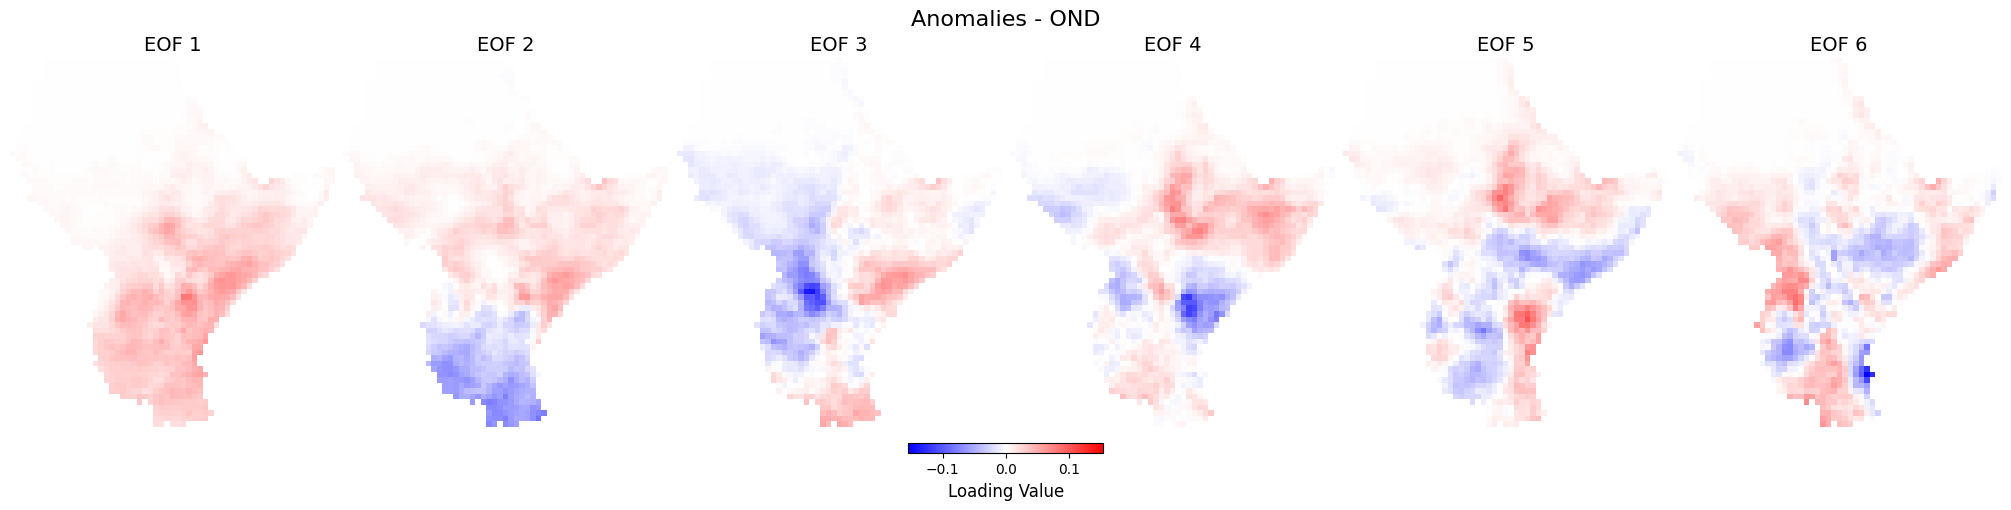

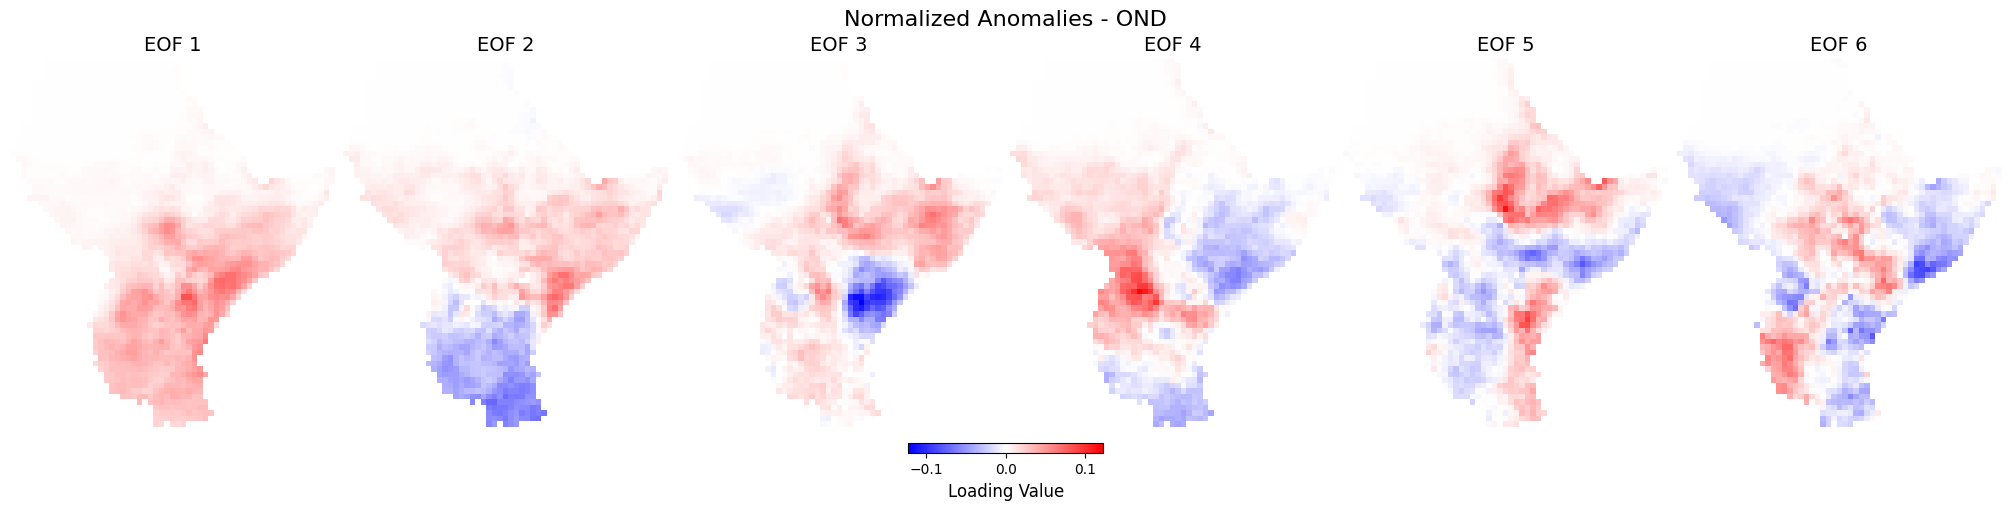

In [19]:
# Reshape the EOFs back to the original spatial dimensions
eofs_anomalies_reshaped = eofs_anomalies.reshape(n_eofs, lat, lon)
eofs_norm_anomalies_reshaped = eofs_ano_normal.reshape(n_eofs, lat, lon)

# Plotting function
def plot_eofs(eofs, title, n_eofs = 1, cmap='bwr'):
    fig, axes = plt.subplots(1, n_eofs, figsize=(20, 5), constrained_layout=True)
    
    vmin, vmax = -np.max(abs(eofs)), np.max(abs(eofs))
    
    for col in range(n_eofs):
        ax = axes[col]
        # Flip the EOF arrays vertically
        flipped_eof = np.flipud(eofs[col])
        im = ax.imshow(flipped_eof, cmap=cmap, interpolation='none', vmin=vmin, vmax=vmax)
        ax.set_title(f'EOF {col + 1}', fontsize=14)
        ax.axis('off')
    
    cbar = fig.colorbar(im, ax=axes, orientation='horizontal', fraction=0.025, pad=0.04)
    cbar.set_label('Loading Value', fontsize=12)
    
    plt.suptitle(title, fontsize=16)
    plt.show()
    
# Plot EOFs for anomalies
plot_eofs(eofs_anomalies_reshaped, 'Anomalies - OND', n_eofs=n_eofs)

# Plot EOFs for normalized anomalies
plot_eofs(eofs_norm_anomalies_reshaped, 'Normalized Anomalies - OND', n_eofs=n_eofs)

##### Get Factor Loadings

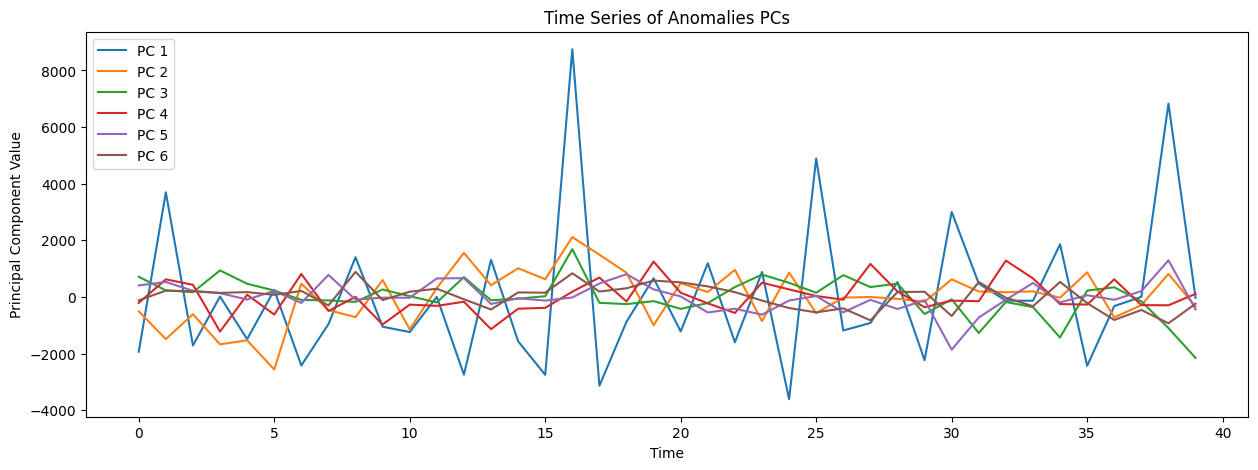

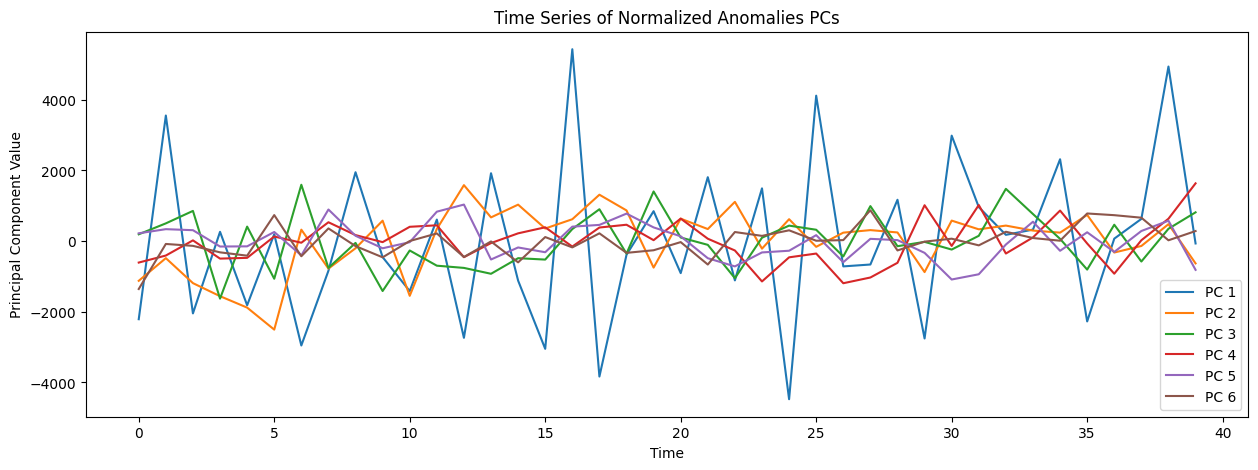

In [20]:
# Function to plot time series of the principal components
def plot_pcs_time_series(pcs, title, size = (15, 5)):
    plt.figure(figsize=size)
    for i in range(pcs.shape[1]):
        plt.plot(pcs[:, i], label=f'PC {i+1}')
    plt.title(f'Time Series of {title}')
    plt.xlabel('Time')
    plt.ylabel('Principal Component Value')
    plt.legend()
    plt.show()

# Plot time series of principal components
plot_pcs_time_series(pcs_anomalies, 'Anomalies PCs')
plot_pcs_time_series(pcs_ano_normal, 'Normalized Anomalies PCs')

In [21]:
# Manual calculation of time series
# NaN handling

# Fill NaNs with 0
anomalies_normal_reshaped_2D_filled = np.nan_to_num(anomalies_normal_reshaped_2D, nan=0.0)
# Fill NaNs in eofs_ano_normal with 0
eofs_ano_normal_filled = np.nan_to_num(eofs_ano_normal, nan=0.0)

pcs_ano_normal_manual = np.dot(anomalies_normal_reshaped_2D_filled, eofs_ano_normal_filled.T)
# Verify the result
print("Shape of pcs_ano_normal_manual:", pcs_ano_normal_manual.shape)

Shape of pcs_ano_normal_manual: (40, 6)


In [22]:
# Get and plot reference time series

filepath_fls = f'/nr/samba/PostClimDataNoBackup/CONFER/EASP/fls/chirps/seasonal/halfdeg_res/refper_1993-2020/prec_full_{season}.csv'
data_prec_full = pd.read_csv(filepath_fls)

# Select the rows where loy equals 1981
selected_loy = 1981
data_prec = data_prec_full[data_prec_full['loy'] == selected_loy]

# Filter data to only include the first n_eofs EOFs
data_prec = data_prec[data_prec['eof'] <= n_eofs]

# Specify the years and EOFs to extract 
train_period = np.arange(year_train_start, year_train_end+1) 
selected_years = train_period

# Extract 'fl' and 'sfl' values and reshape the data to (year, n_eofs)
fl_values = data_prec.pivot(index='year', columns='eof', values='fl').reindex(selected_years, fill_value=np.nan).values
sfl_values = data_prec.pivot(index='year', columns='eof', values='sfl').reindex(selected_years, fill_value=np.nan).values
print(fl_values.shape)
print(sfl_values.shape)


(40, 6)
(40, 6)


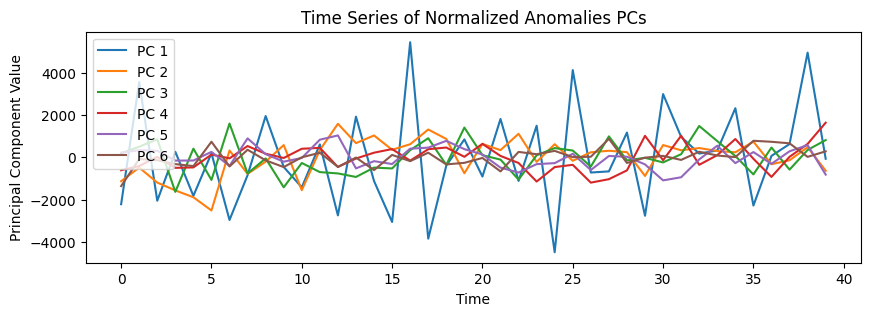

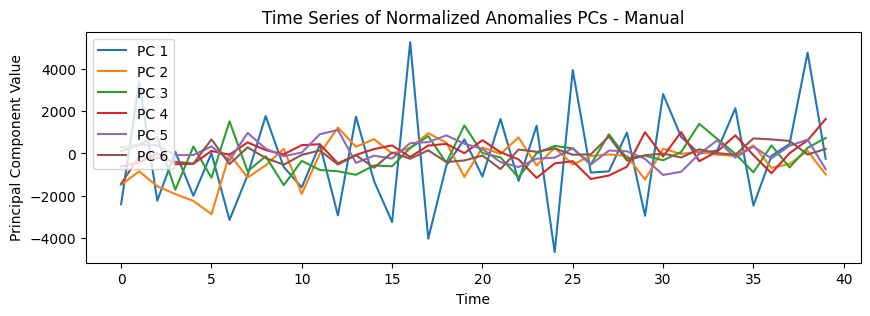

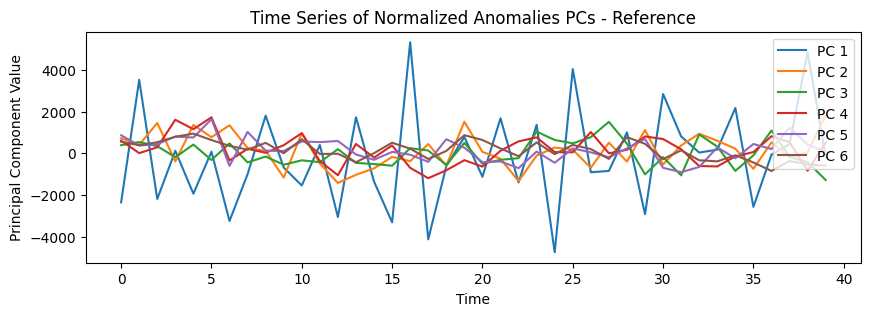

In [23]:
# Plotting normalized anomalies time series
plot_pcs_time_series(pcs_ano_normal, 'Normalized Anomalies PCs', size = (10, 3))

# Plotting manually calculated normalized anomalies time series
plot_pcs_time_series(pcs_ano_normal_manual, 'Normalized Anomalies PCs - Manual', size = (10, 3))

# Plotting reference normalized anomalies time series
plot_pcs_time_series(fl_values, 'Normalized Anomalies PCs - Reference', size = (10, 3))

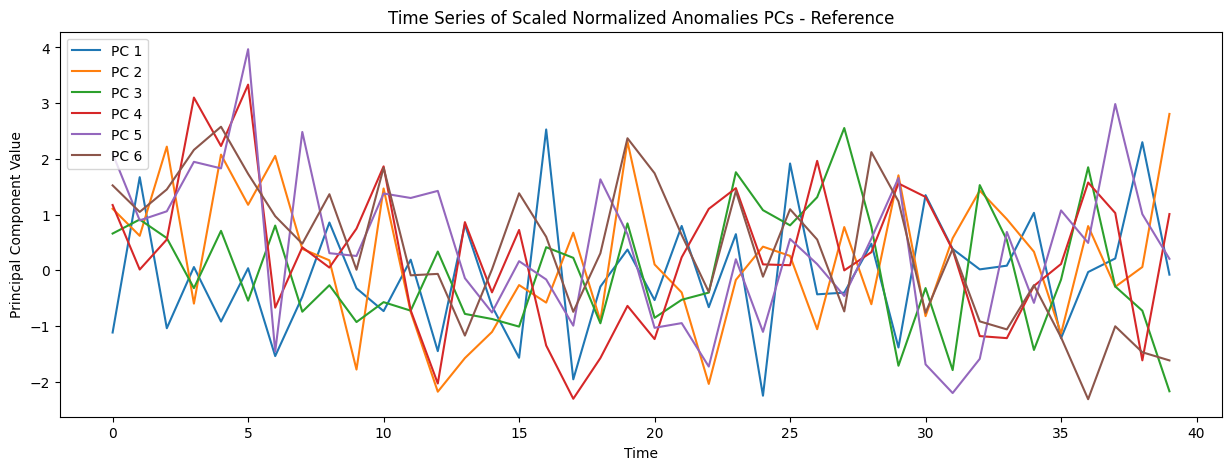

In [24]:
# Plotting reference scaled normalized anomalies time series
plot_pcs_time_series(sfl_values, 'Scaled Normalized Anomalies PCs - Reference')

In [25]:
# def calculate_factor_loadings(anomalies, eofs, train_period):
#     n_years, n_lat, n_lon = anomalies.shape
#     n_eofs = eofs.shape[0]
    
#     # Initialize arrays to store factor loadings, d, and sfl
#     fl_array = np.zeros((n_years, n_eofs))
#     d_array = np.zeros((n_years, n_eofs))
#     sfl_array = np.zeros((n_years, n_eofs))

#     # Print norms of EOFs to check if they are normalized
#     for eof_idx in range(n_eofs):
#         norm_value = np.linalg.norm(eofs[eof_idx])
#         print(f"Norm of EOF {eof_idx + 1}: {norm_value}")
#     for year_idx in range(n_years):
#         for eof_idx in range(n_eofs):
#             eof = eofs[eof_idx]
#             anomaly = anomalies[year_idx]

#             # Replace NaNs with zeros for calculations
#             eof = np.nan_to_num(eof, nan=0.0)
#             anomaly = np.nan_to_num(anomaly, nan=0.0)
            
#             # Calculate the factor loading for this year and EOF mode
#             fl = np.nansum(anomaly * eof)
#             d = np.linalg.norm(eof)  # This is analogous to the eigenvalue scaling in the R code
#             print(d)
#             # Avoid division by zero
#             if d != 0:
#                 # Calculate the scaled factor loading
#                 sfl = (np.sqrt(len(train_period) - 1) * fl) / d  # Use the length of the training period for scaling
#             else:
#                 sfl = np.nan
            
#             # Store the results in arrays
#             fl_array[year_idx, eof_idx] = fl
#             d_array[year_idx, eof_idx] = d
#             sfl_array[year_idx, eof_idx] = sfl
    
#     return fl_array, d_array, sfl_array

In [26]:
# Define the train period 
# train_period = np.arange(year_train_start, year_train_end+1) 

# # Calculate the factor loadings
# fl_array, d_array, sfl_array = calculate_factor_loadings(anomalies_normal, eofs_norm_anomalies_reshaped, train_period)
# print(sfl_array.shape)
# print(sfl_array)

In [27]:
#plot_pcs_time_series(sfl_array, 'Scaled Normalized Anomalies PCs')

In [28]:
# Create xarray Dataset
ds = xr.Dataset(
    {
        'fl': (('year', 'eof'), pcs_ano_normal),
        # 'd': (('year', 'eof'), d_array),
        # 'sfl': (('year', 'eof'), sfl_array),
    },
    coords={
        'year': train_period,
        'eof': np.arange(1, eofs_norm_anomalies_reshaped.shape[0] + 1)
    }
)

# Save to NetCDF file
ds.to_netcdf(f"{test_dir}/fls.nc")
print(f"Factor loadings saved to {test_dir}")

Factor loadings saved to /nr/samba/user/ahellevik/CONFER-WP3/testdata/


In [29]:
#filename_pct_target = f'{percentile_dir}percentiles_{target}_{year_train_start}_{year_train_end}.nc'

#if not path.exists(filename_pct_target):
#    calculate_target_percentiles(target, year_train_start, year_train_end, lon_bnds, lat_bnds, target_dir, filename_pct_target)

data_load = xr.open_dataset(f'{anomaly_dir}refper_{period_clm[0]}-{period_clm[1]}/precip_full_{season}.nc', engine='netcdf4')
lon = data_load.lon.values
lat = data_load.lat.values
data_load.close()

nlon = len(lon)
nlat = len(lat)

## ERA5

If not already available, load ERA5 data, calculate indices, and save out.

Do not use n3, n4.

### Loading data

In [30]:
# sst_data1 = xr.open_dataset(f"{era5_dir}/sst/full.nc") # Original dataset shape: (year, month, lon, lat) = (71, 12, 360, 169)

# Load data
box = [lon_bnds[0], lon_bnds[1], lat_bnds[0], lat_bnds[1]]
load_years = [i for i in range(min(year_train_start, year_clm_start), max(year_train_end+1, year_clm_end+1))]
sst_data = load_raw_data(era5_dir, "sst", box, load_years, season=season)
sst_data

<xarray.Dataset>
Dimensions:  (year: 40, month: 12, lon: 360, lat: 169)
Coordinates:
  * year     (year) int32 1981 1982 1983 1984 1985 ... 2016 2017 2018 2019 2020
  * month    (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
  * lon      (lon) float64 -179.0 -178.0 -177.0 -176.0 ... 178.0 179.0 180.0
  * lat      (lat) float64 -78.0 -77.0 -76.0 -75.0 -74.0 ... 87.0 88.0 89.0 90.0
Data variables:
    sst      (lat, lon, month, year) float32 ...

In [31]:
# Load data
box = [lon_bnds[0], lon_bnds[1], lat_bnds[0], lat_bnds[1]]
uwind200_data = load_raw_data(era5_dir, "uwind200", box, [i for i in range(year_train_start, year_train_end+1)], season=season)
uwind200_data

<xarray.Dataset>
Dimensions:  (year: 40, month: 12, lat: 361, lon: 720)
Coordinates:
  * year     (year) int64 1981 1982 1983 1984 1985 ... 2016 2017 2018 2019 2020
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
Data variables:
    uwind    (year, month, lat, lon) float32 ...

In [32]:
# Load data
box = [lon_bnds[0], lon_bnds[1], lat_bnds[0], lat_bnds[1]]
uwind850_data = load_raw_data(era5_dir, "uwind850", box, [i for i in range(year_train_start, year_train_end+1)], season=season)
uwind850_data

<xarray.Dataset>
Dimensions:  (year: 40, month: 12, lat: 361, lon: 720)
Coordinates:
  * year     (year) int64 1981 1982 1983 1984 1985 ... 2016 2017 2018 2019 2020
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float32 180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
Data variables:
    uwind    (year, month, lat, lon) float32 ...

### Calculate indices

In [33]:
# Define the bounding boxes for the indices
indices_definitions = {
    'n34': {'lat_min': -5, 'lat_max': 5, 'lon_min': -170, 'lon_max': -120},
    'n3': {'lat_min': -5, 'lat_max': 5, 'lon_min': -150, 'lon_max': -90},
    'n4_1': {'lat_min': -5, 'lat_max': 5, 'lon_min': -180, 'lon_max': -150},
    'n4_2': {'lat_min': -5, 'lat_max': 5, 'lon_min': 160, 'lon_max': 180},
    'wpg': {'lat_min': 0, 'lat_max': 20, 'lon_min': 130, 'lon_max': 150},
    'dmi_1': {'lat_min': -10, 'lat_max': 10, 'lon_min': 50, 'lon_max': 70}, # West
    'dmi_2': {'lat_min': -10, 'lat_max': 0, 'lon_min': 90, 'lon_max': 110}, # East
    'ueq850': {'lat_min': -4, 'lat_max': 4, 'lon_min': 60, 'lon_max': 90},
    'ueq200': {'lat_min': -4, 'lat_max': 4, 'lon_min': 60, 'lon_max': 90},
    'wp' : {'lat_min': -15, 'lat_max': 20, 'lon_min': 120, 'lon_max': 160},
    'wnp_1' : {'lat_min': 20, 'lat_max': 35, 'lon_min': 160, 'lon_max': 180},
    'wnp_2' : {'lat_min': 20, 'lat_max': 35, 'lon_min': -180, 'lon_max': -150},
    'wsp_1' : {'lat_min': -30, 'lat_max': -15, 'lon_min': 155, 'lon_max': 180}, 
    'wsp_2' : {'lat_min': -30, 'lat_max': -15, 'lon_min': -180, 'lon_max': -150},
}

#### Functions for index calculations

In [34]:
def standardize_index(data, index_name, indices_definitions = indices_definitions, period_clm = period_clm, year_fcst = year_fcst, month_init = month_init, before = False):
    # Check if trying to calculate for first month and year
    first_year = data['year'].min().item()
    if year_fcst == first_year and month_init == 1:
        raise ValueError("Cannot calculate the index for the first month in the first year of the dataset.")
    
    # Calculate the index for the entire dataset
    if index_name in ["n4", "dmi", "wnp", "wsp"]: 
        region_1 = indices_definitions[f"{index_name}_1"]
        region_2 = indices_definitions[f"{index_name}_2"]
        subset_1 = data.sel(lat=slice(region_1['lat_min'], region_1['lat_max']), lon=slice(region_1['lon_min'], region_1['lon_max']))
        subset_2 = data.sel(lat=slice(region_2['lat_min'], region_2['lat_max']), lon=slice(region_2['lon_min'], region_2['lon_max']))
        
        if index_name == "dmi":
            index_dmi_1 = subset_1.mean(dim=['lat', 'lon'])
            index_dmi_2 = subset_2.mean(dim=['lat', 'lon'])
            
            if before:
                # Select the reference period from the indices
                ref_data_dmi_1 = index_dmi_1.sel(year=slice(period_clm[0], period_clm[1]))
                ref_data_dmi_2 = index_dmi_2.sel(year=slice(period_clm[0], period_clm[1]))

                # Calculate the climatology (mean) and standard deviation during the reference period for both indices
                climatology_dmi_1 = ref_data_dmi_1.mean(dim='year')
                climatology_std_dmi_1 = ref_data_dmi_1.std(dim='year', ddof=1)
                climatology_dmi_2 = ref_data_dmi_2.mean(dim='year')
                climatology_std_dmi_2 = ref_data_dmi_2.std(dim='year', ddof=1)

                # Standardize the entire index data
                standardized_index_dmi_1 = (index_dmi_1 - climatology_dmi_1) / climatology_std_dmi_1
                standardized_index_dmi_2 = (index_dmi_2 - climatology_dmi_2) / climatology_std_dmi_2

                # Calculate the difference between the standardized indices
                index = standardized_index_dmi_1 - standardized_index_dmi_2
            else:
                # Calculate the difference between the indices
                index = index_dmi_1 - index_dmi_2
        else:
            combined_subset = xr.concat([subset_1, subset_2], dim='lat')
            index = combined_subset.mean(dim=['lat', 'lon'])

    elif index_name == "wpg":
        # Calculate the index for the entire dataset
        region_wp = indices_definitions[index_name]
        region_n4_1 = indices_definitions["n4_1"]
        region_n4_2 = indices_definitions["n4_2"]
        subset_wp = data.sel(lat=slice(region_wp['lat_min'], region_wp['lat_max']), lon=slice(region_wp['lon_min'], region_wp['lon_max']))
        subset_n4_1 = data.sel(lat=slice(region_n4_1['lat_min'], region_n4_1['lat_max']), lon=slice(region_n4_1['lon_min'], region_n4_1['lon_max']))
        subset_n4_2 = data.sel(lat=slice(region_n4_2['lat_min'], region_n4_2['lat_max']), lon=slice(region_n4_2['lon_min'], region_n4_2['lon_max']))
        combined_subset_n4 = xr.concat([subset_n4_1, subset_n4_2], dim='lat')
        
        index_wp = subset_wp.mean(dim=['lat', 'lon'])
        index_n4 = combined_subset_n4.mean(dim=['lat', 'lon'])

        if before:
            # Select the reference period from the indices
            ref_data_wp = index_wp.sel(year=slice(period_clm[0], period_clm[1]))
            ref_data_n4 = index_n4.sel(year=slice(period_clm[0], period_clm[1]))

            # Calculate the climatology (mean) and standard deviation during the reference period for both indices
            climatology_wp = ref_data_wp.mean(dim='year')
            climatology_std_wp = ref_data_wp.std(dim='year', ddof=1)
            climatology_n4 = ref_data_n4.mean(dim='year')
            climatology_std_n4 = ref_data_n4.std(dim='year', ddof=1)

            # Standardize the entire index data
            standardized_index_wp = (index_wp - climatology_wp) / climatology_std_wp
            standardized_index_n4 = (index_n4 - climatology_n4) / climatology_std_n4

            # Calculate the difference between the standardized indices
            index = standardized_index_n4 - standardized_index_wp
        else:
            # Calculate the difference between the indices
            index = index_n4 - index_wp

    else:
        region = indices_definitions[index_name]
        subset = data.sel(lat=slice(region['lat_min'], region['lat_max']), lon=slice(region['lon_min'], region['lon_max']))
        index = subset.mean(dim=['lat', 'lon'])

    if before:
        # Standardize the current data point based on data from previous month
        if month_init == 1:
            current_datapoint = index.sel(year=year_fcst-1, month=12)
        else:
            current_datapoint = index.sel(year=year_fcst, month=month_init-1)

        return current_datapoint
    
    else:
        # Select the reference period from the index
        ref_data = index.sel(year=slice(period_clm[0], period_clm[1]))

        # Calculate the climatology (mean) and standard deviation during the reference period
        climatology = ref_data.mean(dim=['year'])
        climatology_std = ref_data.std(dim=['year'], ddof = 1)

        # Standardize the current data point based on data from previous month
        if month_init == 1:
            current_datapoint = index.sel(year = year_fcst-1, month = 12)
            climatology = climatology.sel(month = 12)
            climatology_std = climatology_std.sel(month = 12)
        else:
            current_datapoint = index.sel(year = year_fcst, month = month_init-1)
            climatology = climatology.sel(month = month_init-1)
            climatology_std = climatology_std.sel(month = month_init-1)
        
        anomalies = current_datapoint - climatology
        standardized_anomalies = anomalies / climatology_std
        
        return standardized_anomalies


In [35]:
def standardize_index_diff1(data, index_name, indices_definitions = indices_definitions, period_clm = period_clm, year_fcst = year_fcst, month_init = month_init, before = False):
    # Check if trying to calculate for first month and year
    first_year = data['year'].min().item()
    if year_fcst == first_year and month_init == 1:
        raise ValueError("Cannot calculate the index for the first month in the first year of the dataset.")
    
    # Calculate the index for the entire dataset
    if index_name == "n34":
        region = indices_definitions[index_name]
        subset = data.sel(lat=slice(region['lat_min'], region['lat_max']), lon=slice(region['lon_min'], region['lon_max']))
        index = subset.mean(dim=['lat', 'lon'])
    elif index_name == "dmi":
        region_dmi_1 = indices_definitions["dmi_1"]
        region_dmi_2 = indices_definitions["dmi_2"]
        subset_dmi_1 = data.sel(lat=slice(region_dmi_1['lat_min'], region_dmi_1['lat_max']), lon=slice(region_dmi_1['lon_min'], region_dmi_1['lon_max']))
        subset_dmi_2 = data.sel(lat=slice(region_dmi_2['lat_min'], region_dmi_2['lat_max']), lon=slice(region_dmi_2['lon_min'], region_dmi_2['lon_max']))
        index_dmi_1 = subset_dmi_1.mean(dim=['lat', 'lon'])
        index_dmi_2 = subset_dmi_2.mean(dim=['lat', 'lon'])

        if before:
                # Select the reference period from the indices
                ref_data_dmi_1 = index_dmi_1.sel(year=slice(period_clm[0], period_clm[1]))
                ref_data_dmi_2 = index_dmi_2.sel(year=slice(period_clm[0], period_clm[1]))

                # Calculate the climatology (mean) and standard deviation during the reference period for both indices
                climatology_dmi_1 = ref_data_dmi_1.mean(dim='year')
                climatology_std_dmi_1 = ref_data_dmi_1.std(dim='year', ddof=1)
                climatology_dmi_2 = ref_data_dmi_2.mean(dim='year')
                climatology_std_dmi_2 = ref_data_dmi_2.std(dim='year', ddof=1)

                # Standardize the entire index data
                standardized_index_dmi_1 = (index_dmi_1 - climatology_dmi_1) / climatology_std_dmi_1
                standardized_index_dmi_2 = (index_dmi_2 - climatology_dmi_2) / climatology_std_dmi_2

                # Calculate the difference between the standardized indices
                index = standardized_index_dmi_1 - standardized_index_dmi_2

        else:
            # Calculate the difference between the indices
            index = index_dmi_1 - index_dmi_2
    else:
        print(f"Diff1 not implemented for index {index_name}")
        raise TypeError(f"Diff1 not implemented for index {index_name}")

    # Select the reference period from the index
    ref_data = index.sel(year=slice(period_clm[0], period_clm[1]))

    if before:
        # Calculate the climatology (mean) and standard deviation during the reference period
        climatology = ref_data.mean(dim='year')
        climatology_std = ref_data.std(dim='year', ddof=1)

        # Standardize the entire index data
        standardized_index = (index - climatology) / climatology_std

        # Calculate the differences for all 12 months, including January using December from the previous year
        diff_list = []
        for year in range(period_clm[0], period_clm[1] + 1):
            for month in range(1, 13):
                if month == 1:
                    if year > period_clm[0]:  # Ensure we have the previous year's December data
                        current_value = standardized_index.sel(year=year, month=1)
                        previous_value = standardized_index.sel(year=year-1, month=12)
                        diff = (current_value - previous_value).assign_coords(year=year, month=month)
                        diff_list.append(diff)
                else:
                    current_value = standardized_index.sel(year=year, month=month)
                    previous_value = standardized_index.sel(year=year, month=month-1)
                    diff = (current_value - previous_value).assign_coords(year=year, month=month)
                    diff_list.append(diff)

    else:
        # Calculate the differences for all 12 months, including January using December from the previous year
        diff_list = []
        
        for year in range(period_clm[0], period_clm[1] + 1):
            for month in range(1, 13):
                if month == 1:
                    if year > period_clm[0]:  # Ensure we have the previous year's December data
                        current_value = ref_data.sel(year=year, month=1)
                        previous_value = ref_data.sel(year=year-1, month=12)
                        diff = (current_value - previous_value).assign_coords(year=year, month=month)
                        diff_list.append(diff)
                else:
                    current_value = ref_data.sel(year=year, month=month)
                    previous_value = ref_data.sel(year=year, month=month-1)
                    diff = (current_value - previous_value).assign_coords(year=year, month=month)
                    diff_list.append(diff)
    
    diff_data = xr.concat(diff_list, dim='time')

    climatology = diff_data.mean(dim='time')
    climatology_std = diff_data.std(dim='time', ddof = 1)

    if before:
        # Standardize the current data point based on data from the previous month
        if month_init == 1:
            current_datapoint = standardized_index.sel(year = year_fcst, month = 1)
            previous_datapoint = standardized_index.sel(year = year_fcst-1, month = 12)
        else:
            current_datapoint = standardized_index.sel(year = year_fcst, month = month_init)
            previous_datapoint = standardized_index.sel(year = year_fcst, month = month_init-1)
    else:
        # Standardize the current data point based on data from the previous month
        if month_init == 1:
            current_datapoint = index.sel(year = year_fcst, month = 1)
            previous_datapoint = index.sel(year = year_fcst-1, month = 12)
        else:
            current_datapoint = index.sel(year = year_fcst, month = month_init)
            previous_datapoint = index.sel(year = year_fcst, month = month_init-1)

    # Calculate the difference between the current and previous month
    difference = current_datapoint - previous_datapoint
    
    anomalies = difference - climatology
    standardized_anomalies = anomalies / climatology_std
    
    return standardized_anomalies

#### Code for plotting time series

In [36]:
def prepare_time_series_data(data, index_name, indices_definitions, period_clm, start_year, end_year, months, diff1 = False):
    time_series_data = []

    for year in range(start_year, end_year + 1):
        # print(f"Preparing data for year {year}")
        if (year == start_year) & (months[0] == 1):
            months_loop = months[1:]
        else:
            months_loop = months
        for month in months_loop:
            if diff1:
                standardized_anomaly = standardize_index_diff1(data, index_name, indices_definitions, period_clm, year, month, before = True)
            else:
                standardized_anomaly = standardize_index(data, index_name, indices_definitions, period_clm, year, month)
            if index_name == "ueq850" or index_name == "ueq200":
                standardized_anomaly = standardized_anomaly.uwind.values
            else:
                standardized_anomaly = standardized_anomaly.sst.values
            if month == 1:
                year_prev = year - 1
                month_prev = 12
            else:
                year_prev = year
                month_prev = month - 1

            time_series_data.append({
                'year': year_prev,
                'month': month_prev,
                'standardized_anomaly': standardized_anomaly
            })

    df = pd.DataFrame(time_series_data)
    return df

In [37]:
def process_reference_index(referance_df, start_year, end_year):
    time_series_reference_df = referance_df.copy()
    # Drop unnecessary columns
    columns_to_keep = ["year", "month", "fl"]
    time_series_reference_df = time_series_reference_df[columns_to_keep]
    # Drop duplicate rows
    time_series_reference_df = time_series_reference_df.drop_duplicates()
    # Drop rows with years outside of training period
    start_year, end_year = year_train_start +1, year_train_end  # NB! CHANGE +1 AFTER FIXING STANDARDIZE_INDEX !!!
    time_series_reference_df = time_series_reference_df[
        (time_series_reference_df['year'] >= start_year) & 
        (time_series_reference_df['year'] <= end_year)
    ]
    return time_series_reference_df

In [38]:
def plot_time_series(df, index_name, comparison = False):
    df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
    df = df.sort_values('date')

    plt.figure(figsize=(12, 6))
    if comparison:
        plt.plot(df['date'], df['standardized_anomaly'], label=f"{index_name} Calculated", color='b')
        plt.plot(df['date'], df['fl'], label=f"{index_name} Reference", color='r', linestyle='--')
    else:
        plt.plot(df['date'], df['standardized_anomaly'], label=f"{index_name} Index", color='b')
    plt.title(f"Time Series of {index_name} Index")
    plt.xlabel("Time")
    plt.ylabel(f"{index_name} Index Value")
    plt.legend()
    plt.grid(True)
    plt.show()


#### Calculating and verifying indices

In [39]:
# Shared between all indices
months = list(range(1, 13))
start_year = year_train_start # Add fixing in standardize_index for the first month of the first year, which fails now
end_year = year_train_end
forecast_year = year_fcst
filepath_indices = f'/nr/samba/PostClimDataNoBackup/CONFER/EASP/fls/predictors/refper_1993-2020/indices/'

##### Index N34

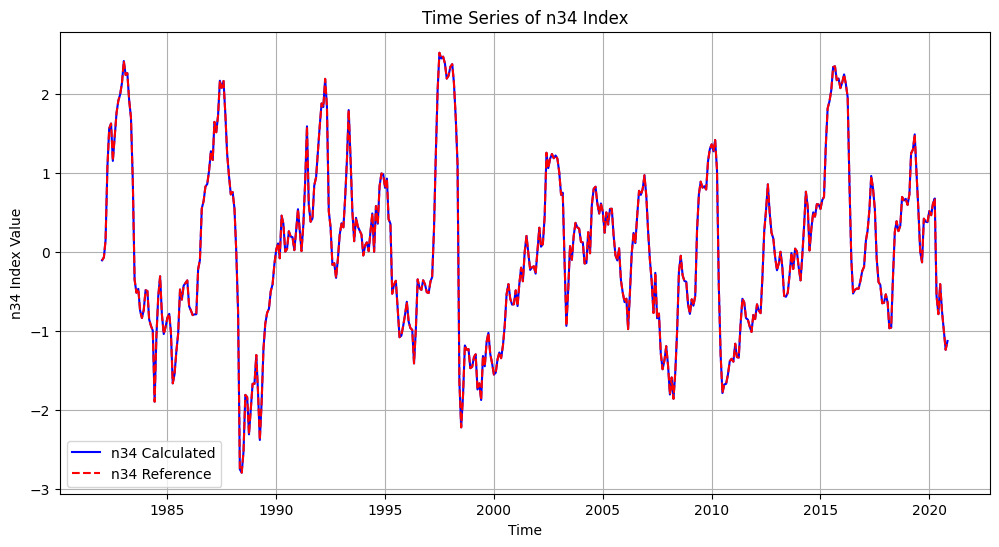

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
0.3730262
Reference value:
0.372994201030477


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
0.5129907
Reference value:
0.513009703875565




In [40]:
time_series_n34_df = prepare_time_series_data(sst_data, "n34", indices_definitions, period_clm, start_year, end_year, months)

# Reference values for index n34
n34_index_reference = pd.read_csv(f"{filepath_indices}n34_full.csv")
time_series_n34_reference_df = process_reference_index(n34_index_reference, start_year, end_year)

# Merge and plot dataframes
merged_df = pd.merge(time_series_n34_df, time_series_n34_reference_df, on=['year', 'month'], suffixes=('_calculated', '_reference'))
plot_time_series(merged_df, "n34", comparison = True)

# Print some values for comparison
for month in range(1, 3):
    print(f"Standardized anomaly (calculated index) for forecast year: {forecast_year}, forecast month = {month} (based on data from month before):")
    print(standardize_index(sst_data, "n34", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).sst.values)
    print(f"Reference value:")
    if month == 1:
        print(n34_index_reference[(n34_index_reference["year"] == forecast_year-1) & (n34_index_reference["month"] == 12)].fl.values[0])
    else:
        print(n34_index_reference[(n34_index_reference["year"] == forecast_year) & (n34_index_reference["month"] == month-1)].fl.values[0])
    print("\n")

##### Index N3

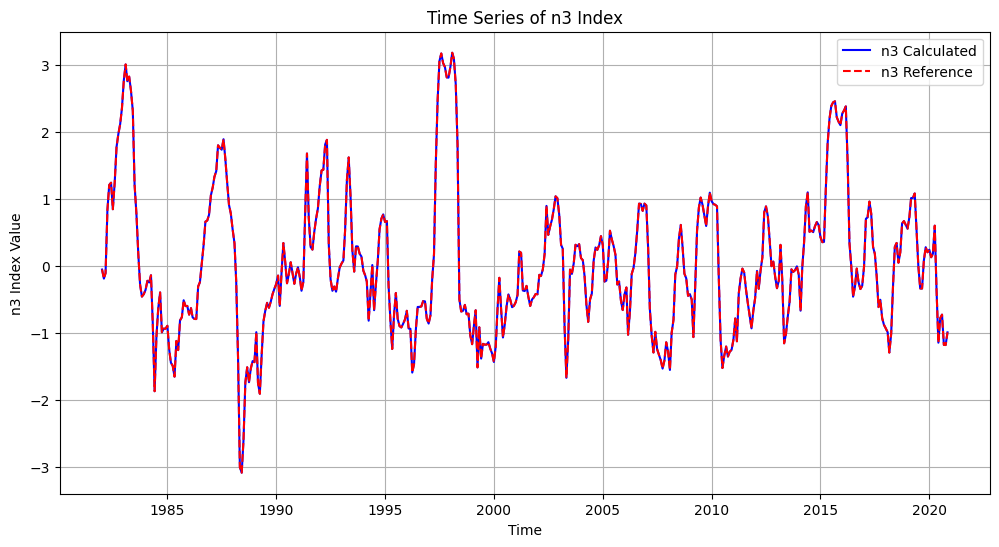

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
0.20605645
Reference value:
0.206019603912169


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
0.2437411
Reference value:
0.243756788163554




In [41]:
time_series_n3_df = prepare_time_series_data(sst_data, "n3", indices_definitions, period_clm, start_year, end_year, months)

# Reference values for index n3
n3_index_reference = pd.read_csv(f"{filepath_indices}n3_full.csv")
time_series_n3_reference_df = process_reference_index(n3_index_reference, start_year, end_year)

# Merge and plot dataframes
merged_df = pd.merge(time_series_n3_df, time_series_n3_reference_df, on=['year', 'month'], suffixes=('_calculated', '_reference'))
plot_time_series(merged_df, "n3", comparison = True)

# Print some values for comparison
for month in range(1, 3):
    print(f"Standardized anomaly (calculated index) for forecast year: {forecast_year}, forecast month = {month} (based on data from month before):")
    print(standardize_index(sst_data, "n3", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).sst.values)
    print(f"Reference value:")
    if month == 1:
        print(n3_index_reference[(n3_index_reference["year"] == forecast_year-1) & (n3_index_reference["month"] == 12)].fl.values[0])
    else:
        print(n3_index_reference[(n3_index_reference["year"] == forecast_year) & (n3_index_reference["month"] == month-1)].fl.values[0])
    print("\n")

##### Index N4

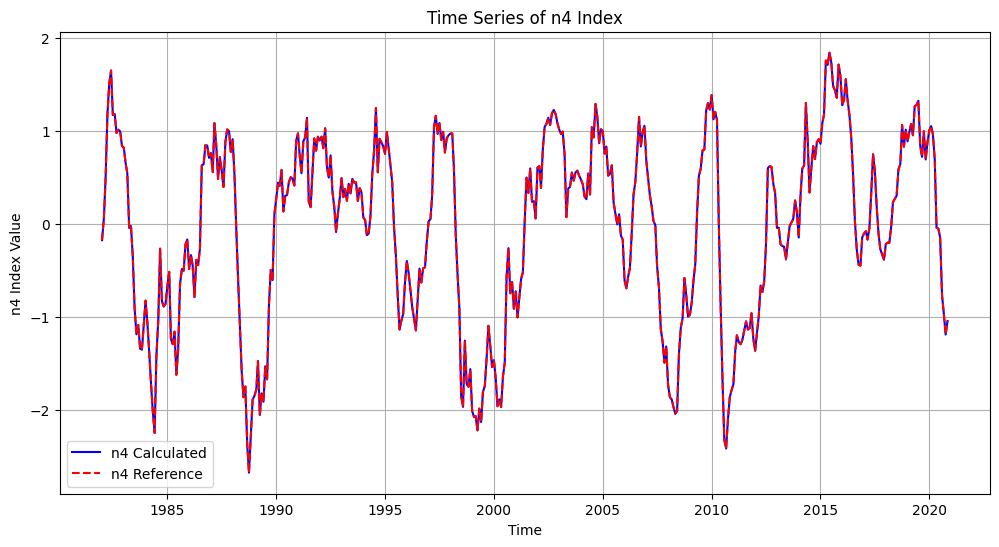

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
0.8791883
Reference value:
0.879144916265894


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
1.0064318
Reference value:
1.00643704571476




In [42]:
time_series_n4_df = prepare_time_series_data(sst_data, "n4", indices_definitions, period_clm, start_year, end_year, months)

# Reference values for index n4
n4_index_reference = pd.read_csv(f"{filepath_indices}n4_full.csv")
time_series_n4_reference_df = process_reference_index(n4_index_reference, start_year, end_year)

# Merge and plot dataframes
merged_df = pd.merge(time_series_n4_df, time_series_n4_reference_df, on=['year', 'month'], suffixes=('_calculated', '_reference'))
plot_time_series(merged_df, "n4", comparison = True)

# Print some values for comparison
for month in range(1, 3):
    print(f"Standardized anomaly (calculated index) for forecast year: {forecast_year}, forecast month = {month} (based on data from month before):")
    print(standardize_index(sst_data, "n4", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).sst.values)
    print(f"Reference value:")
    if month == 1:
        print(n4_index_reference[(n4_index_reference["year"] == forecast_year-1) & (n4_index_reference["month"] == 12)].fl.values[0])
    else:
        print(n4_index_reference[(n4_index_reference["year"] == forecast_year) & (n4_index_reference["month"] == month-1)].fl.values[0])
    print("\n")

##### Index WPG

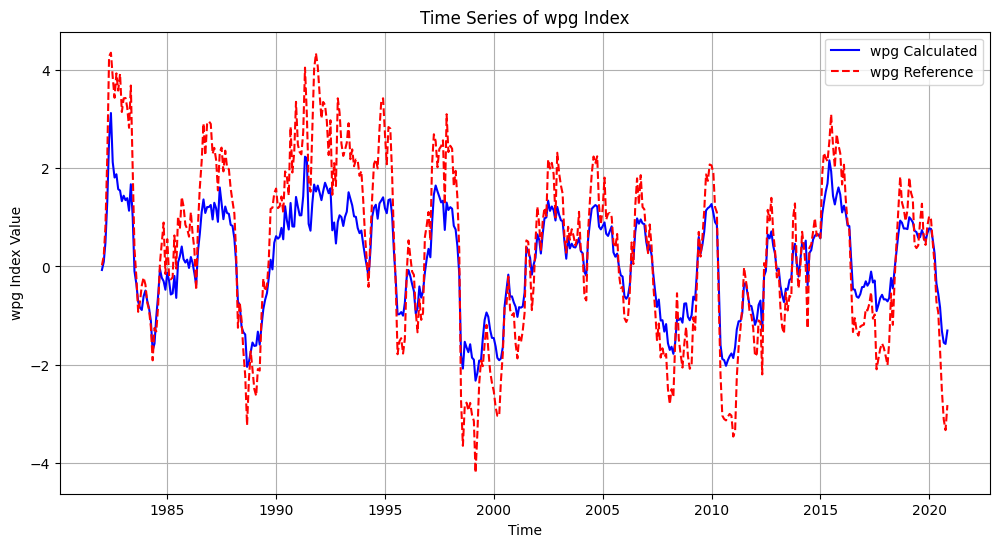

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
0.8253048
Reference value:
0.8253758807116


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
1.0249437
Reference value:
1.02486499573251




In [43]:
time_series_wpg_df = prepare_time_series_data(sst_data, "wpg", indices_definitions, period_clm, start_year, end_year, months)

# Reference values for index wpg
wpg_index_reference = pd.read_csv(f"{filepath_indices}wpg_full.csv")
time_series_wpg_reference_df = process_reference_index(wpg_index_reference, start_year, end_year)

# Merge and plot dataframes
merged_df = pd.merge(time_series_wpg_df, time_series_wpg_reference_df, on=['year', 'month'], suffixes=('_calculated', '_reference'))
plot_time_series(merged_df, "wpg", comparison = True)

# Print some values for comparison
for month in range(1, 3):
    print(f"Standardized anomaly (calculated index) for forecast year: {forecast_year}, forecast month = {month} (based on data from month before):")
    print(standardize_index(sst_data, "wpg", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month, before = True).sst.values)
    print(f"Reference value:")
    if month == 1:
        print(wpg_index_reference[(wpg_index_reference["year"] == forecast_year-1) & (wpg_index_reference["month"] == 12)].fl.values[0])
    else:
        print(wpg_index_reference[(wpg_index_reference["year"] == forecast_year) & (wpg_index_reference["month"] == month-1)].fl.values[0])
    print("\n")

##### Index DMI

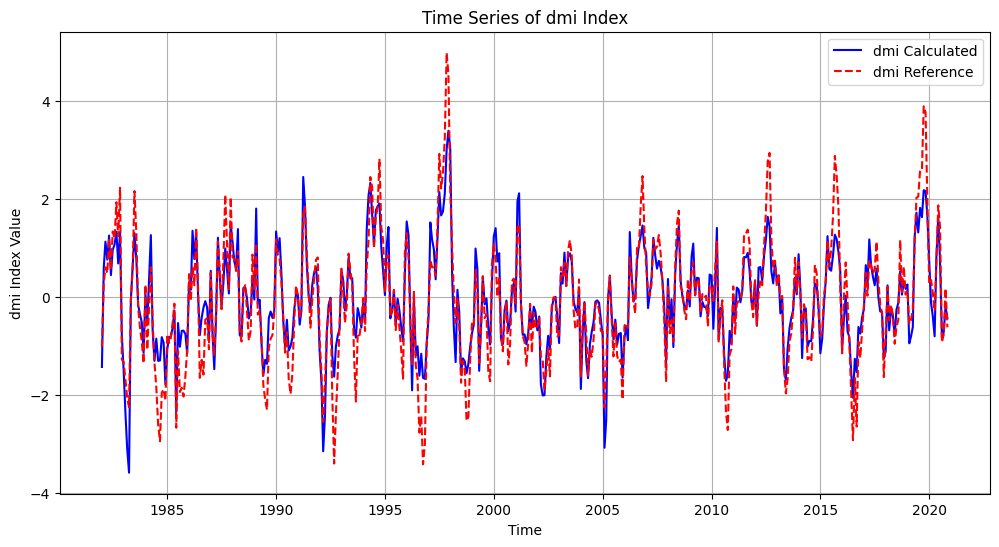

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
1.9419365
Reference value:
1.9418332171625


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
0.2652452
Reference value:
0.265314241227996




In [44]:
time_series_dmi_df = prepare_time_series_data(sst_data, "dmi", indices_definitions, period_clm, start_year, end_year, months)

# Reference values for index dmi
dmi_index_reference = pd.read_csv(f"{filepath_indices}dmi_full.csv")
time_series_dmi_reference_df = process_reference_index(dmi_index_reference, start_year, end_year)

# Merge and plot dataframes
merged_df = pd.merge(time_series_dmi_df, time_series_dmi_reference_df, on=['year', 'month'], suffixes=('_calculated', '_reference'))
plot_time_series(merged_df, "dmi", comparison = True)

# Print some values for comparison
for month in range(1, 3):
    print(f"Standardized anomaly (calculated index) for forecast year: {forecast_year}, forecast month = {month} (based on data from month before):")
    print(standardize_index(sst_data, "dmi", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month, before = True).sst.values)
    print(f"Reference value:")
    if month == 1:
        print(dmi_index_reference[(dmi_index_reference["year"] == forecast_year-1) & (dmi_index_reference["month"] == 12)].fl.values[0])
    else:
        print(dmi_index_reference[(dmi_index_reference["year"] == forecast_year) & (dmi_index_reference["month"] == month-1)].fl.values[0])
    print("\n")

##### Index UEQ850

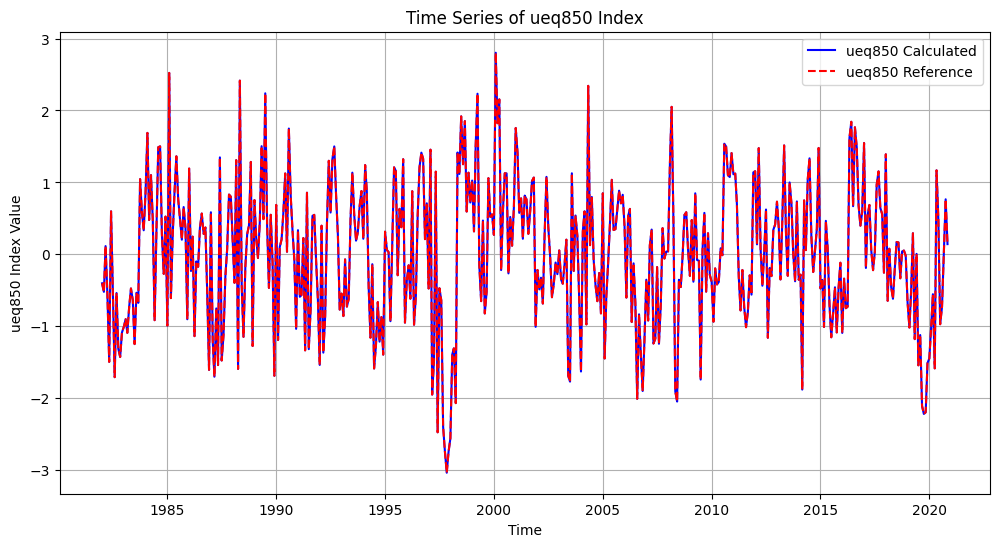

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
-1.512585
Reference value:
-1.51258507670805


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
-1.4468033
Reference value:
-1.44680336146896




In [45]:
time_series_ueq850_df = prepare_time_series_data(uwind850_data, "ueq850", indices_definitions, period_clm, start_year, end_year, months)

# Reference values for index ueq850
ueq850_index_reference = pd.read_csv(f"{filepath_indices}ueq850_full.csv")
time_series_ueq850_reference_df = process_reference_index(ueq850_index_reference, start_year, end_year)

# Merge and plot dataframes
merged_df = pd.merge(time_series_ueq850_df, time_series_ueq850_reference_df, on=['year', 'month'], suffixes=('_calculated', '_reference'))
plot_time_series(merged_df, "ueq850", comparison = True)

# Print some values for comparison
for month in range(1, 3):
    print(f"Standardized anomaly (calculated index) for forecast year: {forecast_year}, forecast month = {month} (based on data from month before):")
    print(standardize_index(uwind850_data, "ueq850", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).uwind.values)
    print(f"Reference value:")
    if month == 1:
        print(ueq850_index_reference[(ueq850_index_reference["year"] == forecast_year-1) & (ueq850_index_reference["month"] == 12)].fl.values[0])
    else:
        print(ueq850_index_reference[(ueq850_index_reference["year"] == forecast_year) & (ueq850_index_reference["month"] == month-1)].fl.values[0])
    print("\n")

##### Index UEQ200

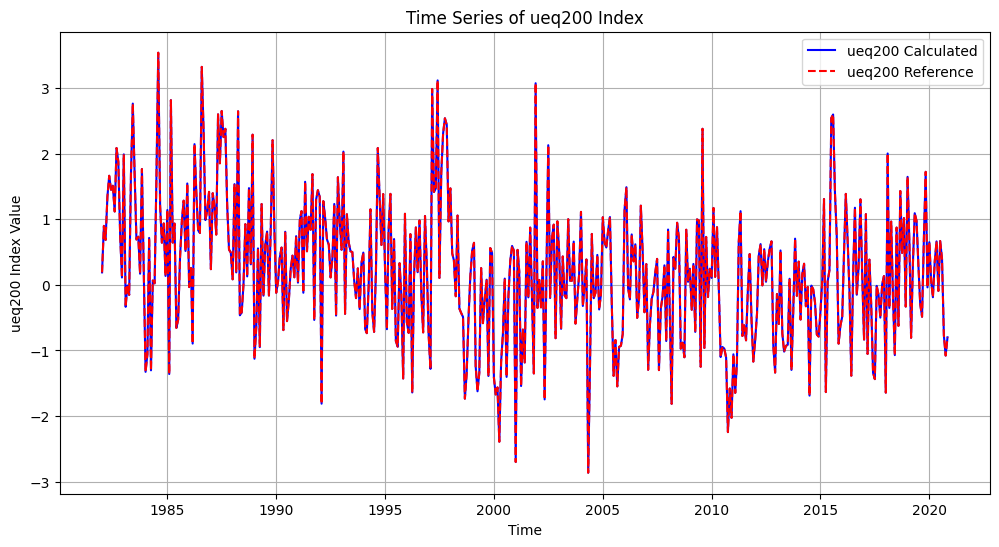

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
-0.038113233
Reference value:
-0.0381129128773105


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
0.65010434
Reference value:
0.65010424548631




In [46]:
time_series_ueq200_df = prepare_time_series_data(uwind200_data, "ueq200", indices_definitions, period_clm, start_year, end_year, months)

# Reference values for index ueq200
ueq200_index_reference = pd.read_csv(f"{filepath_indices}ueq200_full.csv")
time_series_ueq200_reference_df = process_reference_index(ueq200_index_reference, start_year, end_year)

# Merge and plot dataframes
merged_df = pd.merge(time_series_ueq200_df, time_series_ueq200_reference_df, on=['year', 'month'], suffixes=('_calculated', '_reference'))
plot_time_series(merged_df, "ueq200", comparison = True)

# Print some values for comparison
for month in range(1, 3):
    print(f"Standardized anomaly (calculated index) for forecast year: {forecast_year}, forecast month = {month} (based on data from month before):")
    print(standardize_index(uwind200_data, "ueq200", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).uwind.values)
    print(f"Reference value:")
    if month == 1:
        print(ueq200_index_reference[(ueq200_index_reference["year"] == forecast_year-1) & (ueq200_index_reference["month"] == 12)].fl.values[0])
    else:
        print(ueq200_index_reference[(ueq200_index_reference["year"] == forecast_year) & (ueq200_index_reference["month"] == month-1)].fl.values[0])
    print("\n")

##### Index WP

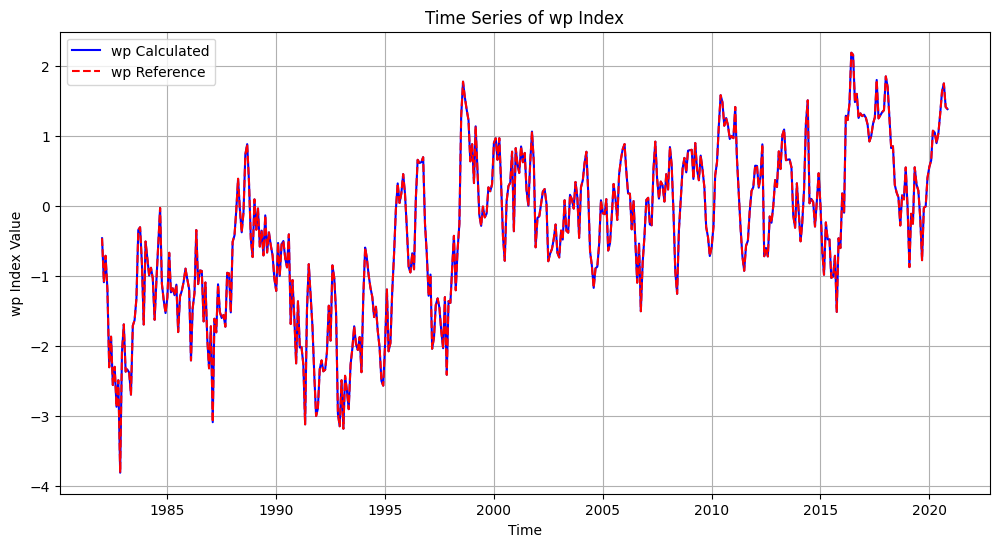

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
0.39634997
Reference value:
0.3965014406094


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
0.55259895
Reference value:
0.552468608350522




In [47]:
time_series_wp_df = prepare_time_series_data(sst_data, "wp", indices_definitions, period_clm, start_year, end_year, months)

# Reference values for index wp
wp_index_reference = pd.read_csv(f"{filepath_indices}wp_full.csv")
time_series_wp_reference_df = process_reference_index(wp_index_reference, start_year, end_year)

# Merge and plot dataframes
merged_df = pd.merge(time_series_wp_df, time_series_wp_reference_df, on=['year', 'month'], suffixes=('_calculated', '_reference'))
plot_time_series(merged_df, "wp", comparison = True)

# Print some values for comparison
for month in range(1, 3):
    print(f"Standardized anomaly (calculated index) for forecast year: {forecast_year}, forecast month = {month} (based on data from month before):")
    print(standardize_index(sst_data, "wp", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).sst.values)
    print(f"Reference value:")
    if month == 1:
        print(wp_index_reference[(wp_index_reference["year"] == forecast_year-1) & (wp_index_reference["month"] == 12)].fl.values[0])
    else:
        print(wp_index_reference[(wp_index_reference["year"] == forecast_year) & (wp_index_reference["month"] == month-1)].fl.values[0])
    print("\n")

##### Index WNP

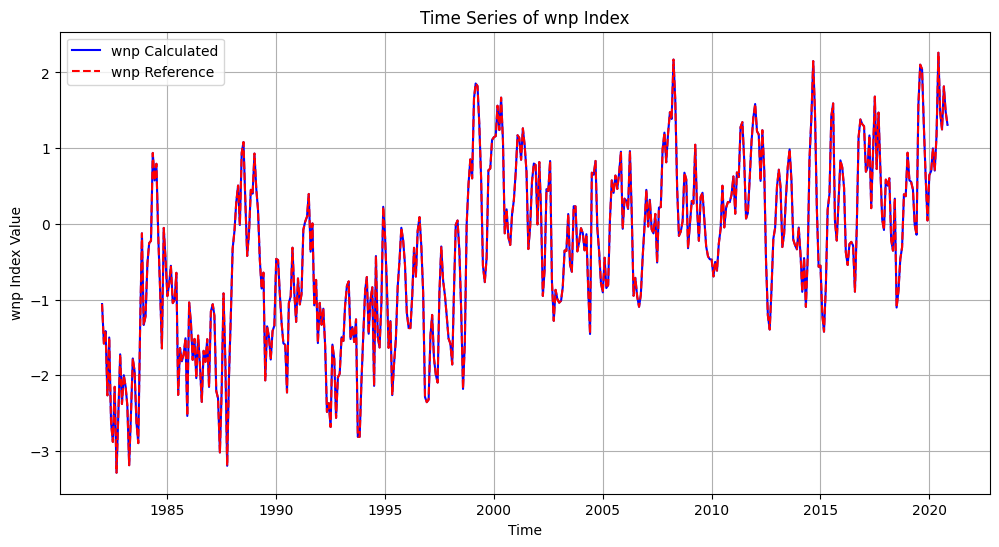

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
0.044063736
Reference value:
0.0439991073142581


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
0.64201736
Reference value:
0.642058242147582




In [48]:
time_series_wnp_df = prepare_time_series_data(sst_data, "wnp", indices_definitions, period_clm, start_year, end_year, months)

# Reference values for index wnp
wnp_index_reference = pd.read_csv(f"{filepath_indices}wnp_full.csv")
time_series_wnp_reference_df = process_reference_index(wnp_index_reference, start_year, end_year)

# Merge and plot dataframes
merged_df = pd.merge(time_series_wnp_df, time_series_wnp_reference_df, on=['year', 'month'], suffixes=('_calculated', '_reference'))
plot_time_series(merged_df, "wnp", comparison = True)

# Print some values for comparison
for month in range(1, 3):
    print(f"Standardized anomaly (calculated index) for forecast year: {forecast_year}, forecast month = {month} (based on data from month before):")
    print(standardize_index(sst_data, "wnp", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).sst.values)
    print(f"Reference value:")
    if month == 1:
        print(wnp_index_reference[(wnp_index_reference["year"] == forecast_year-1) & (wnp_index_reference["month"] == 12)].fl.values[0])
    else:
        print(wnp_index_reference[(wnp_index_reference["year"] == forecast_year) & (wnp_index_reference["month"] == month-1)].fl.values[0])
    print("\n")

##### Index WSP

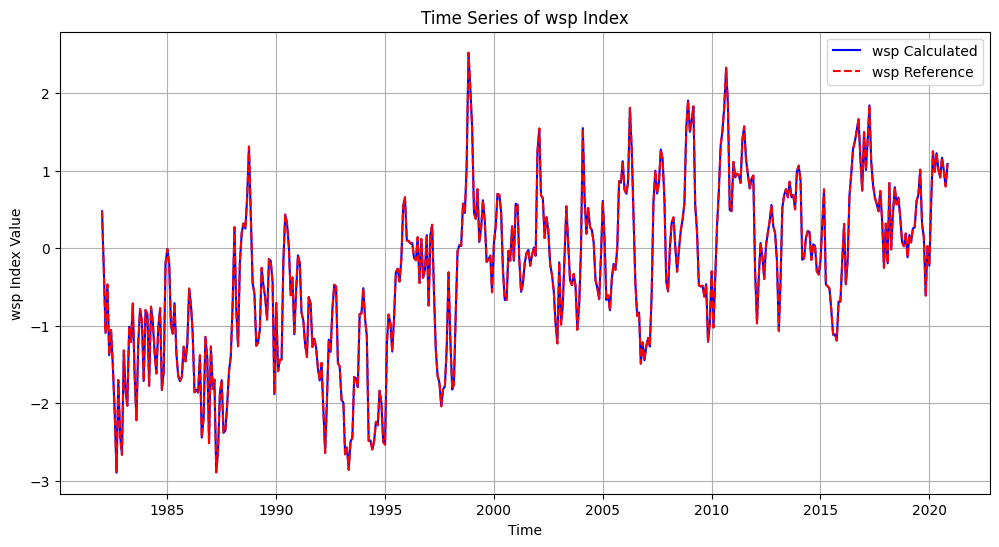

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
0.026317524
Reference value:
0.0263166023317855


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
-0.22396483
Reference value:
-0.223977062664927




In [49]:
time_series_wsp_df = prepare_time_series_data(sst_data, "wsp", indices_definitions, period_clm, start_year, end_year, months)

# Reference values for index wsp
wsp_index_reference = pd.read_csv(f"{filepath_indices}wsp_full.csv")
time_series_wsp_reference_df = process_reference_index(wsp_index_reference, start_year, end_year)

# Merge and plot dataframes
merged_df = pd.merge(time_series_wsp_df, time_series_wsp_reference_df, on=['year', 'month'], suffixes=('_calculated', '_reference'))
plot_time_series(merged_df, "wsp", comparison = True)

# Print some values for comparison
for month in range(1, 3):
    print(f"Standardized anomaly (calculated index) for forecast year: {forecast_year}, forecast month = {month} (based on data from month before):")
    print(standardize_index(sst_data, "wsp", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).sst.values)
    print(f"Reference value:")
    if month == 1:
        print(wsp_index_reference[(wsp_index_reference["year"] == forecast_year-1) & (wsp_index_reference["month"] == 12)].fl.values[0])
    else:
        print(wsp_index_reference[(wsp_index_reference["year"] == forecast_year) & (wsp_index_reference["month"] == month-1)].fl.values[0])
    print("\n")

##### Index WVG

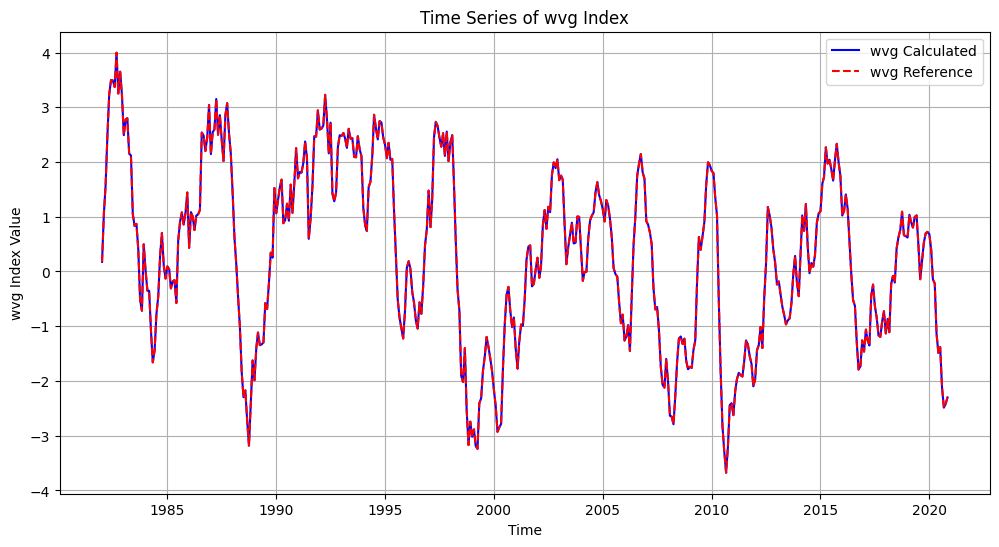

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
0.7236112157503763
Reference value:
0.72353919951408


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
0.6828813155492146
Reference value:
0.682920449770368




In [50]:
# Calculate index

# Merge DataFrames
merge_for_wvg_df = reduce(lambda left, right: pd.merge(left, right, on=['year', 'month']), (
    time_series_n4_df.rename(columns={'standardized_anomaly': 'n4'}),
    time_series_wp_df.rename(columns={'standardized_anomaly': 'wp'}),
    time_series_wnp_df.rename(columns={'standardized_anomaly': 'wnp'}),
    time_series_wsp_df.rename(columns={'standardized_anomaly': 'wsp'}))
)
merge_for_wvg_df['standardized_anomaly'] = merge_for_wvg_df['n4'] - (merge_for_wvg_df['wp'] + merge_for_wvg_df['wnp'] + merge_for_wvg_df['wsp']) / 3
time_series_wvg_df = merge_for_wvg_df

# Reference values for index wvg
wvg_index_reference = pd.read_csv(f"{filepath_indices}wvg_full.csv")
time_series_wvg_reference_df = process_reference_index(wvg_index_reference, start_year, end_year)

# Plot dataframes
merged_df = pd.merge(time_series_wvg_df, time_series_wvg_reference_df, on=['year', 'month'], suffixes=('_calculated', '_reference'))
plot_time_series(merged_df, "wvg", comparison = True)

# Print some values for comparison
for month in range(1, 3):
    print(f"Standardized anomaly (calculated index) for forecast year: {forecast_year}, forecast month = {month} (based on data from month before):")
    n4 = standardize_index(sst_data, "n4", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).sst.values
    wp = standardize_index(sst_data, "wp", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).sst.values
    wnp = standardize_index(sst_data, "wnp", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).sst.values
    wsp = standardize_index(sst_data, "wsp", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month).sst.values
    wvg = n4 - (wp + wnp + wsp) / 3
    print(wvg)
    print(f"Reference value:")
    if month == 1:
        print(wvg_index_reference[(wvg_index_reference["year"] == forecast_year-1) & (wvg_index_reference["month"] == 12)].fl.values[0])
    else:
        print(wvg_index_reference[(wvg_index_reference["year"] == forecast_year) & (wvg_index_reference["month"] == month-1)].fl.values[0])
    print("\n")

##### Index N34_DIFF1

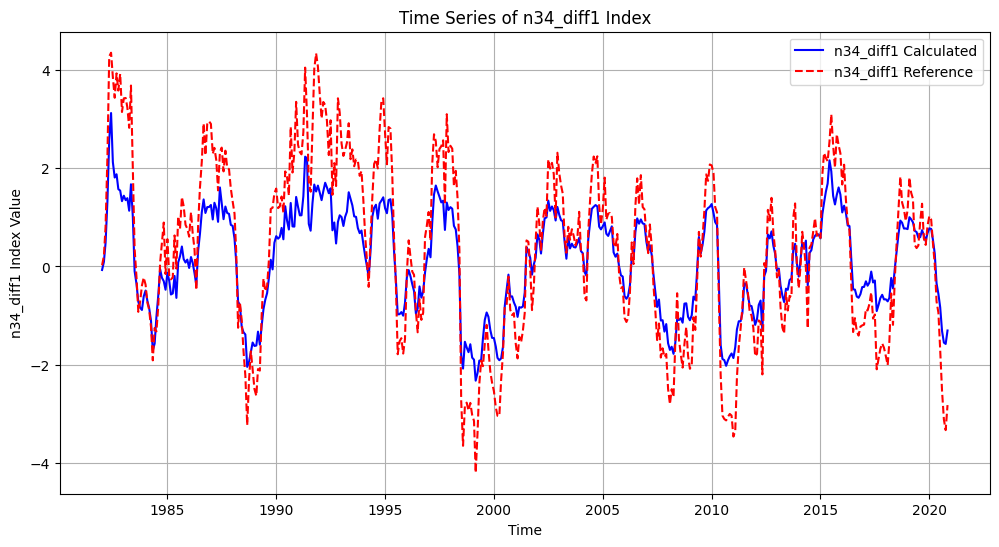

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
0.39967152
Reference value:
-0.0056419748808896


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
-0.13541363
Reference value:
0.140015502845088


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 3 (based on data from month before):
0.4091859
Reference value:
-0.0521589383507099


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 4 (based on data from month before):
0.20173188
Reference value:
0.143377393483854


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 5 (based on data from month before):
-3.4238517
Reference value:
0.0688921184311683


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 6 (based on data from month before):
-0.6310416
Reference value:
-1.2330233310

In [51]:
time_series_n34_diff1_df = prepare_time_series_data(sst_data, "n34", indices_definitions, period_clm, start_year, end_year, months, diff1 = True)

# Reference values for index n34_diff1
n34_diff1_index_reference = pd.read_csv(f"{filepath_indices}n34_diff1_full.csv")
time_series_n34_diff1_reference_df = process_reference_index(n34_diff1_index_reference, start_year, end_year)

# Merge and plot dataframes
merged_df = pd.merge(time_series_wpg_df, time_series_wpg_reference_df, on=['year', 'month'], suffixes=('_calculated', '_reference'))
plot_time_series(merged_df, "n34_diff1", comparison = True)

for month in range(1, 3):
    print(f"Standardized anomaly (calculated index) for forecast year: {forecast_year}, forecast month = {month} (based on data from month before):")
    print(standardize_index_diff1(sst_data, "n34", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month, before = True).sst.values)
    print(f"Reference value:")
    if month == 1:
        print(n34_diff1_index_reference[(n34_diff1_index_reference["year"] == forecast_year-1) & (n34_diff1_index_reference["month"] == 12)].fl.values[0])
    else:
        print(n34_diff1_index_reference[(n34_diff1_index_reference["year"] == forecast_year) & (n34_diff1_index_reference["month"] == month-1)].fl.values[0])
    print("\n")

##### Index DMI_DIFF1

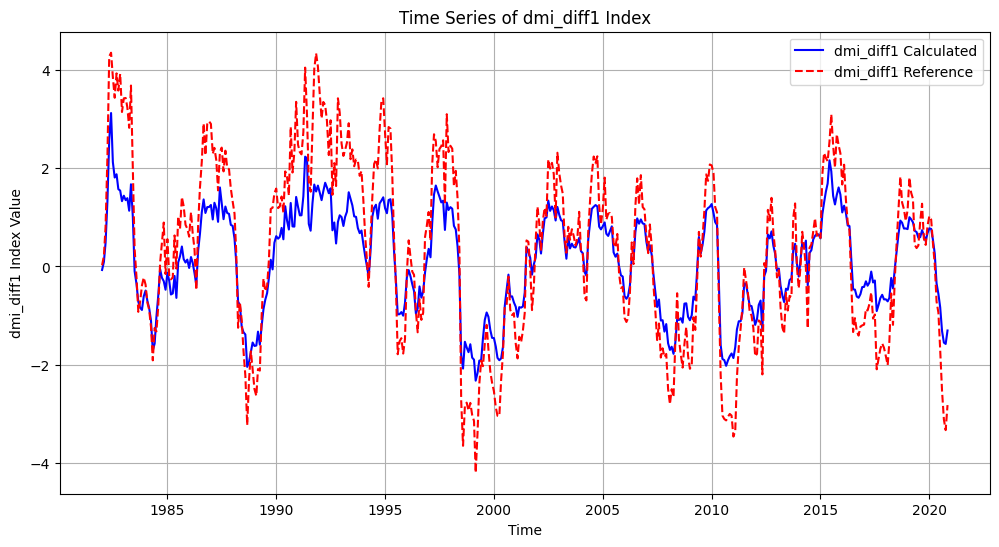

Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 1 (based on data from month before):
-1.4542311
Reference value:
-1.82678177870107


Standardized anomaly (calculated index) for forecast year: 2020, forecast month = 2 (based on data from month before):
0.14539981
Reference value:
-1.6765189759345




In [52]:
time_series_dmi_diff1_df = prepare_time_series_data(sst_data, "dmi", indices_definitions, period_clm, start_year, end_year, months, diff1 = True)

# Reference values for index dmi_diff1
dmi_diff1_index_reference = pd.read_csv(f"{filepath_indices}dmi_diff1_full.csv")
time_series_dmi_diff1_reference_df = process_reference_index(dmi_diff1_index_reference, start_year, end_year)

# Merge and plot dataframes
merged_df = pd.merge(time_series_wpg_df, time_series_wpg_reference_df, on=['year', 'month'], suffixes=('_calculated', '_reference'))
plot_time_series(merged_df, "dmi_diff1", comparison = True)

for month in range(1, 3):
    print(f"Standardized anomaly (calculated index) for forecast year: {forecast_year}, forecast month = {month} (based on data from month before):")
    print(standardize_index_diff1(sst_data, "dmi", indices_definitions, period_clm, year_fcst=forecast_year, month_init=month, before = True).sst.values)
    print(f"Reference value:")
    if month == 1:
        print(dmi_diff1_index_reference[(dmi_diff1_index_reference["year"] == forecast_year-1) & (dmi_diff1_index_reference["month"] == 12)].fl.values[0])
    else:
        print(dmi_diff1_index_reference[(dmi_diff1_index_reference["year"] == forecast_year) & (dmi_diff1_index_reference["month"] == month-1)].fl.values[0])
    print("\n")

## ML model

In [ ]:
import sys
import os

import numpy as np
import pandas as pd
import xarray as xr

from os import path
from warnings import simplefilter
from scipy.stats import spearmanr, pearsonr
from sklearn.linear_model import MultiTaskLassoCV, MultiTaskElasticNetCV
from sklearn.exceptions import ConvergenceWarning

#from joblib import dump

simplefilter("ignore", category=ConvergenceWarning)


predictor = sys.argv[1]                 # 'sst_fls', 'indices', 'combined', 'mjo', or 'wmjo'
regularisation = sys.argv[2]            # 'lasso', 'enfixed', or 'enopt'
interactions = bool(int(sys.argv[3]))   # should interaction terms be used ('0' or '1')
resolution = sys.argv[4]                # spatial resolution of the predictand ('halfdeg', '1deg', '2deg', or '4deg')
month = int(sys.argv[5])                # month in which the forecast is issued; predictors are taken from previous month
season = sys.argv[6]                    # 'MAM', 'JJAS', or 'OND'


data_dir = '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/'

if interactions:
    ia_str = '_iat'
else:
    ia_str = ''

# season_name = {1:'MAM', 2:'JJAS', 3:'OND'}[season]

target_prod = 'chirps'
ref_period = '1993-2020'
mode = 'loyo'                 # 'full' or 'loyo'

#years_cv = [*range(1993,2021)]
years_cv = [*range(1981,2021)]
#years_cv = [*range(1950,2021)]

years_verif = [*range(1993,2021)]
df_year = pd.DataFrame((np.array(years_cv)-2000)/10, index=years_cv, columns=['year'])


print(f'\n Generating {season} forecasts at {resolution} resolution')


# -- Load precipitation factor loadings --------------------------------------------------------------------------------------------------------------------------------------

filename_prec = f'{data_dir}fls/{target_prod}/seasonal/{resolution}_res/refper_{ref_period}/prec_{mode}_{season}.csv'
data_prec = pd.read_csv(filename_prec, index_col=['year','loy','eof'], usecols=['year','loy','eof','fl']).rename(columns={'fl':'prec'})
#years_verif = data_prec.index.get_level_values('loy').unique()


# -- Calculate explained variance by the respective EOFs-----------------------------------------------------------------------------------------------------------------------

refper_start = int(ref_period[:4])
refper_end = int(ref_period[-4:])

nc = xr.open_dataset(f'{data_dir}eofs/{target_prod}/{resolution}_res/refper_{ref_period}/prec_loyo_seasonal_{season}.nc')
nc_subset = nc.sel(loy=slice(years_verif[0],years_verif[-1]))
eigenvalues = (nc_subset.d.values**2) / (refper_end-refper_start)
nc.close()

ntg = 7   # number of precipitation EOFs considered

frac_expl_var = eigenvalues / np.nansum(eigenvalues,axis=0)[None,:]
wgt = pd.DataFrame(np.sqrt(frac_expl_var[:ntg,:].T), index=years_verif, columns=[*range(1,ntg+1)])
#wgt.round(3)



# -- Load predictors ---------------------------------------------------------------------------------------------------------------------------------------------------------

feature_name = []

if predictor in ['indices','combined']:
    # -- Meteorological indices ----------------------------------------------------------------------------------------------------------------------------------------------
    data_indices = []
    feature_name = ['n34','dmi','wvg','wsp','wpg','wp','wnp','nao','n34_diff1','dmi_diff1','sji850','sji200','ueq850','ueq200']
    for index_name in feature_name:
        filename_index = f'{data_dir}fls/predictors/refper_{ref_period}/indices/{index_name}_{mode}.csv'
        data_indices.append(pd.read_csv(filename_index, index_col=['year','month','loy'], usecols=['year','month','loy','fl']).rename(columns={'fl':index_name}))

if predictor in ['sst_fls','combined']:
    # -- SST factor loadings -------------------------------------------------------------------------------------------------------------------------------------------------
    data_sst_fls = []
    for region_name in ['io','atl','ps','pac','nao']:
        filename_regional_fls = f'{data_dir}fls/predictors/refper_{ref_period}/regional_eofs/sst_{region_name}_{mode}_m{month-1}.csv'
        data_sst_fls.append(pd.read_csv(filename_regional_fls, index_col=['year','loy','eof'], usecols=['year','loy','eof','sfl']).rename(columns={'sfl':region_name}))
        feature_name = feature_name + [f'{region_name}{i}' for i in range(1,6)]

if predictor == 'mjo':
    # -- MJO based predictor: average days in each phase ---------------------------------------------------------------------------------------------------------------------
    data_mjo = pd.read_csv(f'{data_dir}/mjo/mjo_dummy.csv', index_col=['year','month'])
    feature_name = data_mjo.columns

if predictor == 'wmjo':
    # -- MJO based predictor: average days in each phase, weighted by amplitude ----------------------------------------------------------------------------------------------
    data_mjo = pd.read_csv(f'{data_dir}/mjo/mjo_dummy_wgt.csv', index_col=['year','month'])
    feature_name = data_mjo.columns


if interactions:
    interaction_names = []
    for i in range(len(feature_name)):
        pr1 = feature_name[i]
        for j in range(len(feature_name)):
            pr2 = feature_name[j]
            interaction_names.append(f'${pr1}*({pr2})_-$')
            interaction_names.append(f'${pr1}*({pr2})_+$')


# -- Loop through cross-validation years, fit models, and make predictions  --------------------------------------------------------------------------------------------------

k = 5    # number of CV folds for hyperparameter optimisation

if mode == 'full':
    nyr = len(years_cv)
elif mode == 'loyo':
    nyr = len(years_cv) - 1

cv_folds = []
for i in range(k):
    idx_test = set(range(i*2,nyr,k*2)).union(set(range(1+i*2,nyr,k*2)))
    idx_train = set(range(nyr)).difference(idx_test)
    cv_folds.append( (list(idx_train), list(idx_test)) )


df_fl_pred_mean = pd.DataFrame(index=years_verif, columns=[f'fl{i}' for i in range(1,ntg+1)])
df_fl_pred_cov = pd.DataFrame(index=years_verif, columns=[f'cov-{i}{j}' for i in range(1,ntg+1)  for j in range(1,ntg+1)])
df_hyperparameters = pd.DataFrame(index=years_verif, columns=['alpha','l1_ratio'])

if interactions:
    df_selected_features = pd.DataFrame(index=years_verif, columns=['year']+feature_name+interaction_names, dtype=int)
else:
    df_selected_features = pd.DataFrame(index=years_verif, columns=['year']+feature_name, dtype=int)

for iyr in years_verif:
#    print(iyr)
    df_target = data_prec.loc[(slice(None),iyr,range(1,ntg+1)),:].unstack().droplevel(level=1).droplevel(level=0, axis=1).fillna(0.).reindex(years_cv)
    if predictor in ['sst_fls','combined']:
        data_sst_fls_yr = []
        for i in range(len(data_sst_fls)):
            data_sst_fls_yr.append(data_sst_fls[i].loc[(slice(None),iyr,slice(None)),:].unstack().droplevel(level=1).loc[:,(slice(None),[*range(1,6)])])
    if predictor in ['indices','combined']:
        data_indices_yr = []
        for i in range(len(data_indices)):
            data_indices_yr.append(data_indices[i].loc[(slice(None),month-1,iyr),:].droplevel(level=(1,2)))
    if predictor == 'sst_fls':
        df_features = pd.concat(data_sst_fls_yr, axis=1).fillna(0.).reindex(years_cv)
        df_features.columns = [f'{column_name[0]}{column_name[1]}' for column_name in df_features.columns]
    elif predictor == 'indices':
        df_features = pd.concat(data_indices_yr, axis=1).fillna(0.).reindex(years_cv)
    elif predictor == 'combined':
        df_features = pd.concat(data_indices_yr+data_sst_fls_yr, axis=1).fillna(0.).reindex(years_cv)
        df_features.columns = [f'{column_name[0]}{column_name[1]}' if len(column_name)==2 else column_name for column_name in df_features.columns]
    elif predictor in ['mjo','wmjo']:
        df_features = data_mjo.loc[(slice(None),month-1),:].droplevel(level=1).reindex(years_cv)
    if mode == 'full':
        y = df_target.to_numpy()
        X = df_features.to_numpy()
    elif mode == 'loyo':
        y = df_target[df_target.index!=iyr].to_numpy()
        X = df_features[df_features.index!=iyr].to_numpy()
   # Feature pre-selection
    feature_idx = [True]+[False]*len(df_features.columns)
    for ift in range(len(feature_idx)-1):
#        pval = [spearmanr(y[:,ipc], X[:,ift])[1] for ipc in range(ntg)]
#        feature_idx[ift] = np.any(np.sort(pval) <= 0.1*np.arange(1,ntg+1)/ntg)
        pval = [pearsonr(y[:,ipc], X[:,ift])[1] for ipc in range(ntg)]
        feature_idx[1+ift] = np.any(np.array(pval)<0.1*wgt.loc[iyr])
    df_features = df_features.iloc[:,feature_idx[1:]]
    df_selected_features.loc[iyr,['year']+df_features.columns.to_list()] = 0
    print(f'{iyr}: {sum(feature_idx)} features selected')
   # Write list of pre-selected features to file
#    with open(f'{data_dir}models/enpps_{predictor}{ia_str}_im{month}_ts{season}_loy{iyr}.txt','w') as tfile:
#        tfile.write('\n'.join(df_features.columns.to_list()))
   # Interactions with b/n/a dummy variables of features
    if sum(feature_idx) == 1:
        df_features = df_year
    elif interactions:
        df_feature_interactions = pd.DataFrame(index=years_cv, columns=[*range(2*len(df_features.columns)**2)])
        k = 0
        for i in range(len(df_features.columns)):
            pr1 = df_features.columns[i]
            for j in range(len(df_features.columns)):
                pr2 = df_features.columns[j]
                df_feature_interactions[k] = df_features[pr1]*(df_features[pr2]<-0.4316)
                df_feature_interactions.rename(columns = {k: f'${pr1}*({pr2})_-$'}, inplace=True)
                k += 1
                df_feature_interactions[k] = df_features[pr1]*(df_features[pr2]>0.4316)
                df_feature_interactions.rename(columns = {k: f'${pr1}*({pr2})_+$'}, inplace=True)
                k += 1
        df_features = pd.concat([df_year, df_features, df_feature_interactions], axis=1)
    else:
        df_features = pd.concat([df_year, df_features], axis=1)
    if mode == 'full':
        X = df_features.to_numpy()
    elif mode == 'loyo':
        X = df_features[df_features.index!=iyr].to_numpy()
    if regularisation == 'lasso':
       # Lasso regression of pre-selected features
        clf = MultiTaskLassoCV(cv=cv_folds, fit_intercept=False, max_iter=5000)
    elif regularisation == 'enfixed':
       # Elastic net regression of pre-selected features with fixed l1_ratio
        clf = MultiTaskElasticNetCV(cv=cv_folds, fit_intercept=False, l1_ratio=.5, max_iter=5000)
    elif regularisation == 'enopt':
       # Elastic net regression of pre-selected features with optimized l1_ratio
        clf = MultiTaskElasticNetCV(cv=cv_folds, fit_intercept=False, l1_ratio=[.1,.5,.7,.9,.95,.99,1.], max_iter=5000)
    clf.fit(X, y)
#    dump(clf, f'{data_dir}models/enpps_{predictor}{ia_str}_im{month}_ts{season}_loy{iyr}.joblib')
    df_hyperparameters.loc[iyr,'alpha'] = clf.alpha_
    if regularisation == 'lasso':
        df_hyperparameters.loc[iyr,'l1_ratio'] = 1.
    else:
        df_hyperparameters.loc[iyr,'l1_ratio'] = clf.l1_ratio_
    ind_active = np.all(clf.coef_!=0, axis=0)
    n_a = sum(ind_active)
    if n_a > 0:
        df_selected_features.loc[iyr,df_features.columns.to_list()] = np.where(ind_active, 1, 0)
    if n_a > 0 and regularisation == 'lasso':
        dgf = 1 + n_a
    elif n_a > 0 and regularisation in ['enfixed','enopt']:
        lam1 = 2*nyr*clf.alpha_*clf.l1_ratio_
        lam2 = nyr*clf.alpha_*(1-clf.l1_ratio_)
        Xa = X[:,ind_active]
        H_l2 = np.dot(Xa, np.linalg.solve(np.dot(Xa.T,Xa)+np.diag(np.full(n_a,lam2,dtype=float)),Xa.T))
        dgf = 1 + sum(np.diag(H_l2))
    else:
        dgf = 1
   # In 'full' mode, we mainly care about the estimated coefficients, in 'loyo' mode we mainly care about the predictions
    if mode == 'full':
        df_coefficients = pd.DataFrame(clf.coef_, index=[f'eof{i}' for i in range(1,ntg+1)], columns=df_features.columns)
        errors = y - clf.predict(X)
        df_fl_pred_cov.loc[:,:] = np.broadcast_to((np.dot(errors.T,errors)/(nyr-dgf)).flatten(), (len(years_verif),ntg**2))
        break
    elif mode == 'loyo':
        df_fl_pred_mean.loc[iyr] = clf.predict(df_features[df_features.index==iyr].to_numpy())
        errors = y - clf.predict(X)
        df_fl_pred_cov.loc[iyr] = (np.dot(errors.T,errors)/(nyr-dgf)).flatten()


if not path.exists(f'{data_dir}fls_pred/{target_prod}/seasonal/{resolution}_res'):
    os.mkdir(f'{data_dir}fls_pred/{target_prod}/seasonal/{resolution}_res')

if not path.exists(f'{data_dir}fls_pred/{target_prod}/seasonal/{resolution}_res/refper_{ref_period}_cvper_{years_cv[0]}-{years_cv[-1]}'):
    os.mkdir(f'{data_dir}fls_pred/{target_prod}/seasonal/{resolution}_res/refper_{ref_period}_cvper_{years_cv[0]}-{years_cv[-1]}')

if mode == 'full':
    df_coefficients.to_csv(f'{data_dir}fls_pred/{target_prod}/seasonal/{resolution}_res/refper_{ref_period}_cvper_{years_cv[0]}-{years_cv[-1]}/coefficients_{predictor}_{regularisation}_{mode}{ia_str}_im{month}_{season}.csv')
    df_fl_pred_cov.to_csv(f'{data_dir}fls_pred/{target_prod}/seasonal/{resolution}_res/refper_{ref_period}_cvper_{years_cv[0]}-{years_cv[-1]}/fls_cov_{predictor}_{regularisation}_{mode}{ia_str}_im{month}_{season}.csv')
elif mode == 'loyo':
    df_fl_pred_mean.to_csv(f'{data_dir}fls_pred/{target_prod}/seasonal/{resolution}_res/refper_{ref_period}_cvper_{years_cv[0]}-{years_cv[-1]}/fls_mean_{predictor}_{regularisation}_{mode}{ia_str}_im{month}_{season}.csv')
    df_fl_pred_cov.to_csv(f'{data_dir}fls_pred/{target_prod}/seasonal/{resolution}_res/refper_{ref_period}_cvper_{years_cv[0]}-{years_cv[-1]}/fls_cov_{predictor}_{regularisation}_{mode}{ia_str}_im{month}_{season}.csv')
    df_hyperparameters.to_csv(f'{data_dir}fls_pred/{target_prod}/seasonal/{resolution}_res/refper_{ref_period}_cvper_{years_cv[0]}-{years_cv[-1]}/hyperparameters_{predictor}_{regularisation}_{mode}{ia_str}_im{month}_{season}.csv')
    df_selected_features.to_csv(f'{data_dir}fls_pred/{target_prod}/seasonal/{resolution}_res/refper_{ref_period}_cvper_{years_cv[0]}-{years_cv[-1]}/selected_features_{predictor}_{regularisation}_{mode}{ia_str}_im{month}_{season}.csv')




Run LASSO model to predict precipitation EOFs based on indices.

In [53]:
# do it

Visualize fitted coefficients

In [54]:
# do it

Load indices for the forecast year and use the previously fitted model to make a forecast

In [55]:
prob_fcst_below, prob_fcst_above = calculate_tercile_probability_forecasts(season, year_fcst, month_init, period_train, period_clm, indices_dir, anomaly_dir, eof_dir, fcst_dir)

FileNotFoundError: [Errno 2] No such file or directory: '/home/michael/nr/samba/PostClimDataNoBackup/CONFER/EASP/eofs/chirps/halfdeg_res/refper_1993-2020/prec_full_seasonal_OND.nc'

Depict as a map.

In [ ]:
plot_fields (fields_list = [prob_fcst_below, prob_fcst_above],
          lon = lon,
          lat = lat,
          lon_bounds = lon_bnds,
          lat_bounds = lat_bnds,
          main_title = f'Predicted tercile probabilities for {season} precipitation amounts',
          subtitle_list = ['below normal','above normal'],
          vmin = 0.333,
          vmax = 1,
          cmap = ['Oranges','Greens'],
          unit = '')